In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 한글 폰트 설정
try:
    import subprocess

    # 폰트 패키지 설치
    subprocess.run(['apt-get', 'update'], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    subprocess.run(['apt-get', 'install', '-y', 'fonts-nanum'], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    # 설치한 폰트 캐시 갱신
    subprocess.run(['fc-cache', '-fv'], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    # 나눔고딕 폰트 경로 등록
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    fm.fontManager.addfont(font_path)

    # Matplotlib 설정 적용
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False
    print("한글 폰트 설정 완료")
except Exception as e:
    # 폰트 설치 실패 시 기본 폰트 사용
    plt.rcParams['font.family'] = 'DejaVu Sans'
    print(f"한글 폰트 설정 실패: {e}")

한글 폰트 설정 완료


In [ ]:
import os
import pandas as pd
import numpy as np


def validate_participant_timeline(df, uid):
    """
    참가자의 주차별 lastUpdate 시간이 올바른 순서인지 검증
    + 중복 주차 검증 + NaN 값 검증 추가

    Args:
        df: response 데이터프레임 (해당 참가자만)
        uid: 참가자 UID

    Returns:
        tuple: (is_valid, issues_list)
        - is_valid: True/False
        - issues_list: 발견된 문제점들의 리스트
    """
    issues = []
    is_valid = True

    # NaN 값 검사
    nan_issues = []

    # week 컬럼에 NaN이 있는지 확인
    if df['week'].isna().any():
        nan_count = df['week'].isna().sum()
        nan_issues.append(f"week 컬럼에 NaN 값 {nan_count}개")
        is_valid = False

    # lastUpdate 컬럼에 NaN이 있는지 확인
    if df['lastUpdate'].isna().any():
        nan_count = df['lastUpdate'].isna().sum()
        nan_issues.append(f"lastUpdate 컬럼에 NaN 값 {nan_count}개")
        is_valid = False

    # PHQ-9 관련 컬럼들의 NaN 확인
    phq_nan_weeks = []
    for i in range(9):
        answer_cols = [f"PHQ-9[{i}].answers[{j}]" for j in range(4)]
        for col in answer_cols:
            if col in df.columns:
                nan_rows = df[df[col].isna()]
                if not nan_rows.empty:
                    weeks_with_nan = nan_rows['week'].dropna().unique()
                    phq_nan_weeks.extend(weeks_with_nan)

    if phq_nan_weeks:
        unique_phq_nan_weeks = sorted(set(phq_nan_weeks))
        nan_issues.append(f"PHQ-9 문항에 NaN 값이 있는 주차: {unique_phq_nan_weeks}")
        is_valid = False

    # GAD-7 관련 컬럼들의 NaN 확인
    gad_nan_weeks = []
    for i in range(7):
        answer_cols = [f"GAD-7[{i}].answers[{j}]" for j in range(4)]
        for col in answer_cols:
            if col in df.columns:
                nan_rows = df[df[col].isna()]
                if not nan_rows.empty:
                    weeks_with_nan = nan_rows['week'].dropna().unique()
                    gad_nan_weeks.extend(weeks_with_nan)

    if gad_nan_weeks:
        unique_gad_nan_weeks = sorted(set(gad_nan_weeks))
        nan_issues.append(f"GAD-7 문항에 NaN 값이 있는 주차: {unique_gad_nan_weeks}")
        is_valid = False

    # NaN 관련 이슈들을 전체 이슈 리스트에 추가
    issues.extend(nan_issues)

    # 중복 주차 검사
    week_counts = df['week'].value_counts()
    duplicate_weeks = week_counts[week_counts > 1].index.tolist()

    if duplicate_weeks:
        is_valid = False
        issues.append(f"중복된 주차 발견: {sorted(duplicate_weeks)} (각각 {[week_counts[w] for w in sorted(duplicate_weeks)]}개)")

    # 주차별로 정렬된 데이터 확인
    df_sorted = df.sort_values('week').reset_index(drop=True)
    weeks = sorted(df_sorted['week'].unique())

    # 0주차만 있는 경우 체크
    if len(weeks) == 1 and weeks[0] == 0:
        is_valid = False
        issues.append("0주차 설문만 존재함 (추적 데이터 없음)")
        return is_valid, issues

    # 최소 2개 주차 이상 있어야 함 (0주차 + 최소 1개 추가 주차)
    if len(weeks) < 2:
        is_valid = False
        issues.append(f"설문 데이터 부족: 총 {len(weeks)}개 주차만 존재 (최소 2개 주차 필요)")
        return is_valid, issues

    # 0주차가 없는 경우 체크
    if 0 not in weeks:
        is_valid = False
        issues.append("0주차(베이스라인) 설문이 없음")

    # 연속된 주차가 있는지 확인
    expected_weeks = list(range(min(weeks), max(weeks) + 1))
    missing_weeks = [w for w in expected_weeks if w not in weeks]

    if missing_weeks:
        is_valid = False
        issues.append(f"누락된 주차: {missing_weeks}")

    # 중복 주차가 있으면 시간 순서 검증은 건너뛰기 (이미 invalid 처리됨)
    if not duplicate_weeks:
        # lastUpdate 시간이 주차 순서대로 증가하는지 확인
        prev_timestamp = None
        prev_week = None

        for idx, row in df_sorted.iterrows():
            current_week = row['week']
            current_timestamp = row['last_ts']

            if prev_timestamp is not None:
                if current_timestamp <= prev_timestamp:
                    is_valid = False
                    issues.append(
                        f"시간 순서 오류: {prev_week}주차({prev_timestamp}) → "
                        f"{current_week}주차({current_timestamp})"
                    )

            prev_timestamp = current_timestamp
            prev_week = current_week

    return is_valid, issues


def preprocess_response():
    """
    response.csv 파일을 읽어서
    1) 데이터 품질 검증 (주차별 lastUpdate 시간 순서 확인 + 중복 주차 검증)
    2) 각 주차별 lastUpdate를 last_update_map에 저장하고
    3) PHQ-9, GAD-7 원점수를 계산한 후
    4) (uid, week, phq9_score, gad7_score, phq9_label, gad7_label) 형태로 long format DataFrame 생성
    5) 디버깅용으로 출력하고
    6) CSV로 저장
    """
    path = get_file_path("response.csv")

    try:
        df = pd.read_csv(path, encoding="cp949")
        if df.empty:
            print(f"⚠️ 경고: {path} 파일이 비어있습니다.")
            return None
    except pd.errors.EmptyDataError:
        print(f"⚠️ 오류: {path} 파일이 비어있거나 읽을 수 없습니다.")
        return None
    except FileNotFoundError:
        print(f"⚠️ 오류: {path} 파일을 찾을 수 없습니다.")
        return None
    except Exception as e:
        print(f"⚠️ 오류: {path} 파일 읽기 실패 - {str(e)}")
        return None

    df["last_ts"] = pd.to_datetime(df["lastUpdate"])

    # === 데이터 품질 검증 ===
    print("===== 데이터 품질 검증 (중복 주차 + NaN 값 포함) =====")

    # 참가자별로 검증 (현재는 단일 참가자지만 확장 가능하도록)
    unique_uids = df['uid'].unique()

    for uid in unique_uids:
        uid_df = df[df['uid'] == uid].copy()
        is_valid, issues = validate_participant_timeline(uid_df, uid)

        print(f"\n참가자 {uid}:")
        print(f"  - 데이터 유효성: {'✓ 정상' if is_valid else '✗ 문제 발견'}")

        if not is_valid:
            print("  - 발견된 문제점들:")
            for issue in issues:
                print(f"    • {issue}")

            # 상세 타임라인 출력
            print("  - 상세 타임라인:")
            timeline_df = uid_df.sort_values('week')[['week', 'last_ts']].reset_index(drop=True)
            for idx, row in timeline_df.iterrows():
                print(f"    {row['week']}주차: {row['last_ts']}")

            # 중복 주차가 있는 경우 추가 정보 출력
            week_counts = uid_df['week'].value_counts()
            duplicate_weeks = week_counts[week_counts > 1].index.tolist()
            if duplicate_weeks:
                print("  - 중복 주차 상세:")
                for week in sorted(duplicate_weeks):
                    duplicate_rows = uid_df[uid_df['week'] == week][['week', 'last_ts']]
                    print(f"    {week}주차 ({week_counts[week]}개):")
                    for idx, row in duplicate_rows.iterrows():
                        print(f"      - {row['last_ts']}")

            # NaN 값 상세 정보 출력
            if uid_df.isna().any().any():
                print("  - NaN 값 상세:")
                for col in uid_df.columns:
                    if uid_df[col].isna().any():
                        nan_weeks = uid_df[uid_df[col].isna()]['week'].dropna().unique()
                        if len(nan_weeks) > 0:
                            print(f"    {col}: {sorted(nan_weeks)}주차")

            print(f"\n⚠️  경고: 참가자 {uid}의 데이터는 문제가 있어 분석에서 제외하는 것을 권장합니다.")

            # 여기서 처리를 중단하거나 계속할지 선택할 수 있음
            user_choice = input(f"\n참가자 {uid} 데이터를 계속 처리하시겠습니까? (y/n): ").lower().strip()
            if user_choice != 'y':
                print("처리를 중단합니다.")
                return None
        else:
            print("  ✓ 모든 검증 통과")

    print("===================================================\n")

    # === 주차별 마지막 업데이트 시각 저장 ===
    for wk in sorted(df["week"].unique()):
        ts = df.loc[df["week"] == wk, "last_ts"].iloc[0]
        last_update_map[wk] = ts

    # === PHQ-9 점수 계산 ===
    phq_item_cols = []
    for i in range(9):
        answer_cols = [f"PHQ-9[{i}].answers[{j}]" for j in range(4)]
        df[f"PHQ9_item_{i}"] = (
            df[answer_cols].fillna(False)
            .apply(lambda row: sum(int(row[col]) * j for j, col in enumerate(answer_cols)), axis=1)
        )
        phq_item_cols.append(f"PHQ9_item_{i}")

    df["phq9_score"] = df[phq_item_cols].sum(axis=1)

    # === GAD-7 점수 계산 ===
    gad_item_cols = []
    for i in range(7):
        answer_cols = [f"GAD-7[{i}].answers[{j}]" for j in range(4)]
        df[f"GAD7_item_{i}"] = (
            df[answer_cols].fillna(False)
            .apply(lambda row: sum(int(row[col]) * j for j, col in enumerate(answer_cols)), axis=1)
        )
        gad_item_cols.append(f"GAD7_item_{i}")

    df["gad7_score"] = df[gad_item_cols].sum(axis=1)

    # === 라벨링 추가 ===
    df["PHQ_label"] = pd.cut(
        df["phq9_score"],
        bins=[-1, 4, 9, 19, 27],
        labels=[0, 1, 2, 3],
        right=True
    ).astype(int)

    df["GAD_label"] = (df["gad7_score"] >= 6).astype(int)

    # === long format 생성 ===
    df_long = df[["uid", "week", "phq9_score", "gad7_score", "PHQ_label", "GAD_label"]].copy()
    df_long = df_long.rename(columns={
        "phq9_score": "PHQ_9",
        "gad7_score": "GAD_7"
    })

    # === 디버깅 출력 ===
    print("===== 주차별 PHQ-9 / GAD-7 Raw 점수 및 라벨 (long format, 디버깅용) =====")
    print(df_long)
    print("=====================================================================\n")

    print("===== 주차별 lastUpdate (디버깅용) =====")
    for wk, ts in last_update_map.items():
        print(f"week {wk} lastUpdate: {ts}")
    print("========================================\n")

    # === CSV 저장 ===
    output_path = os.path.join(OUTPUT_DIR, "response_processed.csv")
    df_long.to_csv(output_path, index=False, encoding="utf-8-sig")
    print(f"Processed (PHQ-9/GAD-7 + 라벨링 포함) 파일 저장 완료: {output_path}")

    return df_long


def get_valid_participants(response_file_paths):
    """
    여러 참가자의 response 파일들을 검증하여 유효한 참가자 목록을 반환
    (중복 주차 검증 포함)

    Args:
        response_file_paths: [(uid, file_path), ...] 형태의 리스트

    Returns:
        dict: {'valid': [uid_list], 'invalid': [(uid, issues_list), ...]}
    """
    results = {'valid': [], 'invalid': []}

    for uid, file_path in response_file_paths:
        try:
            df = pd.read_csv(file_path, encoding="cp949")

            if df.empty:
                results['invalid'].append((uid, ["파일이 비어있음"]))
                continue

            df["last_ts"] = pd.to_datetime(df["lastUpdate"])

            is_valid, issues = validate_participant_timeline(df, uid)

            if is_valid:
                results['valid'].append(uid)
            else:
                results['invalid'].append((uid, issues))

        except pd.errors.EmptyDataError:
            results['invalid'].append((uid, ["파일이 비어있거나 읽을 수 없음"]))
        except FileNotFoundError:
            results['invalid'].append((uid, ["파일을 찾을 수 없음"]))
        except Exception as e:
            results['invalid'].append((uid, [f"파일 읽기 오류: {str(e)}"]))

    return results


# 사용 예시 함수
def batch_validate_participants(base_dir, uid_list):
    """
    여러 참가자를 일괄 검증하는 함수
    (중복 주차 검증 포함)

    Args:
        base_dir: 기본 데이터 경로
        uid_list: 검증할 참가자 UID 리스트
    """
    file_paths = []
    for uid in uid_list:
        file_path = os.path.join(base_dir, uid, "response.csv")
        if os.path.exists(file_path):
            file_paths.append((uid, file_path))
        else:
            print(f"⚠️  파일이 존재하지 않음: {file_path}")

    results = get_valid_participants(file_paths)

    print("===== 일괄 참가자 검증 결과 (중복 주차 + NaN 값 포함) =====")
    print(f"✓ 유효한 참가자 ({len(results['valid'])}명): {results['valid']}")
    print(f"✗ 문제가 있는 참가자 ({len(results['invalid'])}명):")

    for uid, issues in results['invalid']:
        print(f"  - {uid}:")
        for issue in issues:
            print(f"    • {issue}")

    return results

In [ ]:
# 여러 참가자 UID 리스트
participant_uids = [
    # # 가천대 - 정상군
    # "y2al2cxSWkRL3rFadwAR5EmVPCu2",
    # "4h7ZeEamUBfcU0EnYGtNZ62nnAP2",
    # "WCbACPaBNuhUi313NtAp4bMr4xX2",
    # "SF3OKBppJOYdGucR2vffiNF0sJO2",
    # "jt6QwpW77iQgiKRAOTbFUJGofQg2",
    # "wqD6BnkBH7SHuKc70SdVYG4i4nA3",
    # "loQKPAEgx1bBAvGop4cr9HqfCwn2",
    # "op5CaFL4JRfyA9kAZ97sEgFxh5g2",
    # "vFjJEGZ10TZjDlJwCn5lDXQFDx42",
    # "KPqggsTAIIVIYjdqiakRwzSI3I42",
    # "X5MBIpEoL5clm96GCz9vKgq0byq1",
    # "hQfxP4Z6LfVVEqbJHLUcJr8cesf2",
    # "EqZtfwIKvgh7g2fZq6WJrHm47KJ2",
    # "e0jyBp4xj6Qa64lsowXMs6favz13",
    # "EykFY0NKgJVZRfI8fGCMoZ4NPc22",
    # "FG6WOuZMWtgArSWGCi9MIgu4KVo1",
    # "96AOPONmdGeAwZNwMtXcRumiCqV2",
    # "OR2z2fOOaIM8M2obfI4YvSd7Cz03",
    # "W1hZkqBeWCUTVBX6rx9OeHmaWx63",

    # # 강동성심병원 - 정상군
    # "I2nKhm0rvYd96ywiVfbGpfOQFE32",
    # "5wL99Hz7QYPiySCW2teF2tBtmlk2",
    # "oGLOCyilo0elY7adqUoJuRlkl3j1",
    # "N1n8YgJ48xU0r75pYobIshltJnz2",
    # "ExoMFXdUO8eDZN2efTyFmDeRi053",
    # "VgNcNWYXFjNkMLttGllrhYJ52sa2",
    # "ZAnZkABTojO2LcVBYRwem3tfqzp2",

    # # 서울아산병원 - 환자군
    # "PXLmbsfuL4eoS2n6BMREXCrfY113",
    # "H5xpe8R0pMQNybyFmD6fpptb5s12",
    # "WyZcaFSyPmXQiLM6G6KZgqhfW9J2",
    # "aEbEJ4v5ZXOGXpRj4con8TY5Oks1",
    # "OtvWlOKX52Zi1Qyky0yYrFxvEGT2",
    # "tZknnycQKNdJYvmp3OSSNLY6Ku92",
    # "JHXGbmkWxYOrH4mKT31aXvOaU1I3",
    # "xwF5EYpuNHWTygGcwlYLnzg8bh03",
    # "m6FdrKdppgX6lMlarwVy3Xln8Ln2",
    # "ikJ9Dd8TwcbfqHdhudcX645JWgW2",
    # "1GvF1usWS7hqE0MNNiUO5otBiqf1",
    # "7thgMUjx6CZ3qxwlOawPKm2SqMo2",
    # "rGwyh0S2FNQdchiNh5paWejBTzo2",
    # "baXYZZcSdeVQOJiogHgziaoNAbn1",

    # # 서울아산병원 - 정산군
    # "Oomx2JFsrGbKmYyOq1ct8NYk7z82",
    # "uDQ9GdVc4ueX4BiskQdyAuYfCHA3",
    # "k4ibZrPD5pc289uu22bv9miehc32",
    # "eUwByxZ4lgQX4hsl0imAOcOREtP2",
    # "83evcKPrCQSHUzB7DUMgm7znqZC2",
    # "Q1jqAtootNVXo9cDCXL97xyiXYf2",
    # "q1SarlLwBoW7GdVe6Vg51j1ANxh2",
    # "IwJUDCL8YjYCerKZP1z1k2PUS7D2",
    # "CjTj06sFOOPba1Mg8xNhG46i2tj2",
    # "5unRty9QOGZ9Iv7KjIORHV0WswS2",
    # "G0DyLxp6rSNX8h11g1WOwQXZMeD2",
    # "fxdmvG1S0BSVmAfXlyIYt0MTZJr2",
    # "ToRvcWlDAcTVyLMA2edXhrH3KyJ3",
    # "4UWnR0zwegfrulhl8Yyd8sGAKe53",
    # "W6ESCqhIBkOlgJZYujZhbq0UYmT2",
    # "AoywjjoT51exBG1yC61DFvM76vZ2",
    # "MSBmNjBwPMQ0A3MsgaxcS4P8tsp2",
    # "Rz4kRBkSnFRupY1u87TxfBweqwg2",
    # "2wLmio4sHCWbOTHZTErXioBIRZf1",
    # "dDU4SYX50eXKN7f2QAdLs1OMAiP2",
    # "80zeIxqrIEgGgJPgOQgMwX7nOT32",
    # "KqXja5PP1wPumFNN5C8BfMxqKIr2",
    # "Cj0sZ8IPwbUAzqcG19vNPPsqN1m1",
    # "JHiGItxjdmRozQ49pDZxRby0r3I2",
    # "jKOT40d3wcUB77ehVDZq8SE9oe33",
    # "GFMjx2d5TjcsHo9DZHCjcLU8duA2",
    # "XyJ8MhCcnWTyJgvMQD5IIPYZsRF2",
    # "haHum2WPRYWzyMS1cKF3RgiK7v32",
    # "tTV3xcHnb8XjlhWOIJIW3PLSYYl2",
    # "ePr5sUM0fQPpcvLVcINiLja4NuC2",
    # "vnPdDmEkTXgltZkdZkt2LP0Ugkj2",
    # "Xx6vUUMSb0WfaHfjVhsHdspor7K2",
    # "lLHMV2WML3hqimD7SIuTj32ATvB3",
    # "QOUOApiF8SVaeAtytmXt7mw8HA03",
    # "K7CjlhAeiodczGUksUf8DWvCt7X2",
    # "zmi3wP5u5pOJmEGe0jR3TnJvm773",
    # "taQfRxpJuzdt3yjIScOwhYoMRY52",
    # "o6PGddNfmuShFKUZVmM6b2bAWep2",
    # "r0vAthkdY3c66LyOhSdrAeam3Ij2",
    # "VCjFOtNTK9ZNHfUabVgtxAIhHJj1",
    # "WoZWK0wyGwaTSZFeuvZA2JvJMhw2",
    # "sMU9XSX8uhQQd2Ttlh78gRr7KeE3",
    # "R72qg31MLZZoI72nMF3vGfw0bHm1",
    # "heoP6v9ZvoU1sIVCfwVHUScFrZF3",
    # '3UEsxHSHjYPYfP9WEuu0jzf2pkl2',
    # "bg5v0Mfh8tdMvYQlF31Mi3wd21s1",
    # "Z2pm3vJ0jPgMxSQ3rxgovZpTkea2",
    # "hu8IV2pJeOXItYXEDUfGun72Lbz2",
    # "L1VCAhyvdhSU0h7VbPtxwqgqyQy1",
    # "4pAekaGEf1WibyMcKKpbwu37Ri03",
    # "GIPhhsXWHRTLr7XgCGK3XDzslXj1",
    # "sZpDyZQ2l7RhPakSxSuNhicTvH13",
    # "FhYrpNaNzcQbePfOKJsa0afQxJH3",
    # "63w0tc0IqBa5Gl92LcWVFCqjkPT2",
    # "9rQrU8JK8ifOHVZ8ymjr5I1yuBm2",
    # "tk9AwgdUMXRg6bJQR0NbA7OQ04b2",
    # "bgghQR0EEJMyhJeiMo9VtmZ7eu42",
    # "uWsG20EiDXcpfwEwmfI6UAYp69g1",
    # "NklJib8FF0XcWa9mPC2TFFLCaTN2",
    # "42KPnw5t7rdVmDlLFPW15WEMzh62",
    # "0sTcz0wwmwY1dnJKqcd60B3iKbB2",
    # "2nWfZvQOgVZZr5VgDmOsjFMtUvs2",
    # "ANfn22R3Eld5F3KWNOw0sBptZwu2",
    # "Gkrk3Pl3o0azrwosUm6p29aXixk1",
    # "ETPVtobC2VVmyh6aPSTzKSBKMnV2",
    # "SNBifvshy8g4Co5tX7OyjUiC6m03",
    # "W0ccGTA85OTE8BSBptnBlA38Ojx1",
    # "8qRTNTKpYpfWGZsf29AZqZ0P6323",
    # "5hqwfalRRHNbY4eVuBtTWzjroDc2",
    # "QmeHp2Yi3odmnCkeXOlqYxmoBYJ3",
    # "4z7CsrB3s3ZwAgDuarbxl3RhEDh1",
    # "EAJMgBzU76SwjDopnIWyJxW6fki1",
    # "aMpsxiaNGmajOIH74BpNf5QvNVi2",
    # "rdDhlRqlz9gB7j30oFGAlfHJpYn2",
    # "Fp2syYAFS7beGeRBx2um76JJCtx2",
    # "Lxt6n0zkyfelWCQPrAFhFs5aojK2",

    # # 서울성모병원 - 정상군
    # "bXVbRHyeeOh5rOKbXLt1SKn8vrn2",
    # "waI6JChfDoUVkuW5kmvW2bJOPOA3",
    # "iJpzChvek5MhrYWSPId1JVHuWXm2",
    # "umXXCvRip8cjadwQ3kQNoZkhJeg2",
    # "KjsZnASC5sfrNCvRFIxbO7IIDKq2",
    # "P0kRFGUli8cJulUuTmtRi5PLriR2",
    # "yMzMQz23StTpxtu9ScfrLfMQV0j1",
    # "6kLjDCFYFtWnX0BDsQljcoELxjJ3",
    # "txplGFnF3qhTUtJUDG75M5BaYOJ2",
    # "Qh3iXlVbCQWQqlmEIUxRYIYJiqi2",
    # "Gpc0saa1JhSaii2fCbQBpEbaP2h2",
    # "gqmAMbW457ZNGasQQzBBFIt8q402",
    # "9ycEnzts5dTmJgpvA35EJKXvoLE3",
    # "XIThCReyKlcyqiydo7VtJ343Jfl2",
    # "JdQ6W58AwAP7Lwues1Y64Uxc2na2",
    # "6gRJl7FUH2M0vA1HvnWEt0P6rmv1",
    # "j0zJ2V3zBNWEFRFdc4ufdgUZdZr1",
    # "p8jTe4oWnJejTqaX8U3WuwdvMaG3",
    # "1VbFGUyQMXbYPSNCNwu5vCfwHB92",
    # "5pAmCmwj0NPBq8OJuy8tqOj9W392",
    # "Pa2Ni3hjtoN0DVmo7dM5fp2j7Sh2",

    # # 칠곡경북대 - 정상군
    # "VI0TvYpJWLQf7JSJCVG718rszGJ3",
    # "cJLvMPKbl3fQ1A0vCjUJS2EYCw22",
    # "m7RDDHUSiJQIQTwYR9pEwoD7QDC2",
    # "vwOZI6z8dgdsJWxLwJYfFygR9Nw2",
    # "PO3Qxe9FIRUDGQcEfNZfVQOVhQn1",
    # "7GamDqyg35SdUfCoSSwpejf6dC93",
    # "Z7umRTeBskMz0yXysZbzfPtN0oI3",
    # "WYIeVpnKvyQkXtiJHTdGR07WV5o2",
    # "MyFpvTFalJNAbC85S06skSi9rKo1",
    # "LOKFwOfHGZM3oyEbJ8HGrrmUVrm2",
    # "k1p6YenHC0OsLhixJxYyrtJDFeI2",
    # 'Sluge4UM1MaFRtbBiB9axQqzZZG3',
    # 'bDPrs9zPMzfZRpoYmn3CGxTk1mU2',
    # 'D0x7QV9SPUWdYsJHGmrHgOqwC7J3',
    # '1pViJZhu99YeCh56mmP6kP15I3D3',
    # 'KOaFOgmDcNVVtQ2VbZTNGfBk8wc2',
    # 'eeYE8n7DitMIgu21OcsY627U5mq1',
    # 'TKbzfGxa41QWMBBJyLqaVmEp7un2',
    # 'X88eXNWQh8eOCJgSZtpnYTsn3AD2',
    # 'zs4t6rwODnNfuGIUdMyxHWTnhXE2',
    # 'dbFqd7kWu3fuVxHjSjVikz2srSn1',
    # '1Hz4yAJxCoTTi57RYgf3ogPy3ys2',
    # 'fkju3JVpONWGhwmirkD4HOLw9b43',
    # "oHG5UbhEBaScPtLtk9UFLddQGIZ2",
    # '2W7fndVuiyVBcwKp9JiXcvTDU1Z2',
    # 'EkgMnlrQ1ASNRW1NR9RN2g6aCu92',
    # "StmqQxI3uXZ911CtY5mUkCcWVJm1",
    # "4WK5JkUOmdSYD1w6SUHkS3J1CX52",
    # "KPCWJFcS9YbjlMXzpZYQvVXuDqC2",
    # "HvLwlijJ2Yeu91oxbm3s7QTIvFI3",
    # "g2G5CiBYEbURb0dO0850iKpHJik1",
    # "OdBVC2cvGmfirYojBaN4Tq95ttB2",
    # "f5ZldHCgjpbjhUbyi9eggOW71183",
    # "h6qwuPjTR9XIYQI3F3Lou4OJjI73",
    # "VnqXjeECC4SNSPbaZaYzXnufedq1",
    # "9MIlRmwORLeIqZDfpY2WIsf0K093",
    # 'XKZzDfOfiiNhQ0O7IPc5YfngpoF3',

    # 칠곡경북대 - 환자군
    "4doXR8hI0JSXznrwYYtTljpc6cg1",
    "hRhfc3YyImSzHKzZm1506yBeTKH2",
    "NnuMQdSBo3SWM7WWOtSBC4PFlG23",
    "td46cH8h5KgoaeXZNBA0OLC1zd53",
    "KA8yeFvJuaaVmRlbXcxzgJq6vSx1",

    # # 성균관대 - 정상군
    # "xGDXZgHjcXZIfoykkoWJh9vNa062",
    # "W8a8p8BR18gjcVblxHJmSx9VCw73",
    # "yZVJVOmADhgoxA29lEdOWLfz8iH2",
    # "OHoIlVenjohVPcTT66H8rrYsnqx2",
    # "tcSrQ5uZSSQNRVdbhNlYsZQU25R2",
    # "tJF9vigAn5W4ShSnmhcSOYdBLni2",
    # "hgnGOjSajah981MOvywye33TEM62",
    # "TGkqvN0HWafhnw9z3wb2khtIyKJ2",
    # "mDCzskfJA2Mft2RfWI30e8FPGAB3",
    # "05U1A5bmcnUUycZ6SYAdqhuu3ck2",
    # "MOhTYzQ0CJcHmvq7CtleTXOl1Ks2",
    # 'JJLep71uYeV50Ig4BT8mfn3IUxS2',
    # "L7Qe4AeWSBXp4xcHlF4nX8lsIoB2",
    # 'Zw5Jn7C6Rggb9rvtCaDq8j63TM52',
    # 'p1cEP4wIodealmvx9YC2hll8tGp2',
    # "gO5OAiKMktUg5iSuqK5tlxmvgLf1",
    # "ShoCBjfWiRYIHeIMOTWeLpmbt3k1",
    # 'nZLgDv3lndZWa965MPELzbrFXAm2',
    # "NrUfIiD6bEQc942bWzo8ImOHS122",
    # "UivvJSypeSPCoZbKUTNuo4v5pQi2",
    # "fK2NGZ4V3OXQprIVyj6zYXIhgBV2",
    # "aBfTnjlLlGdfjLsn8B6ua2t6qpb2",
    # 'S5DawwLXYiPkxM5EzyUOW0EtlZD3',
    # "P7cfqcpMaaNuZW5M1ad4I1Sn9iV2",
    # 'SM3SVyLB7qbFrPOuAAyxjN7rksI3',
    # "V6IbkEl3pwPNjBD2i5XHbCh6BNI2",
    # "XItA5jutdDVYh0wUoeKJBIuH1nv2",
    # "l7WjHA6yrEObrm4e9R9N1ljdQ3g1",
    # "eQJEDfNsyJOSaQ4CFa2SC2pS5Vl1",
    # "BUma5y5BwENhWkQpnHGQZXvIKKD2",
    # "1iQKSFfjfXNDgNAFrSOdtSo92Ft1",
    # "qLOg7QTdpRathSWgXGbav18SG2a2",
    # "JlxwgbKj9Yd69RzIGasmj8vvtE53",
    # "UQDucAjRs4QOAGxajxElgi1nnr52",
    # "MGWomNO28PgvMizPfgvIf0jZ7mQ2",
    # "6MrfVVUFRXU0astIVH71rgnO2PZ2",
    # "75yZ8FFP4fR4DF8DdFyrWKlFxa93",
    # "S2nDvhXIQsTb93Dk4zRMj6t5vjC2",
    # "JL0JiyLzXNO7k5MQHoEZNakYO7t1",
    # "fHY4uPtKQkcy3uLDGy3JNviaYw83",

]

# 일괄 검증
BASE_DIR = "/content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터"
results = batch_validate_participants(BASE_DIR, participant_uids)

# 유효한 참가자만으로 분석 진행
valid_participants = results['valid']


===== 일괄 참가자 검증 결과 (중복 주차 + NaN 값 포함) =====
✓ 유효한 참가자 (5명): ['4doXR8hI0JSXznrwYYtTljpc6cg1', 'hRhfc3YyImSzHKzZm1506yBeTKH2', 'NnuMQdSBo3SWM7WWOtSBC4PFlG23', 'td46cH8h5KgoaeXZNBA0OLC1zd53', 'KA8yeFvJuaaVmRlbXcxzgJq6vSx1']
✗ 문제가 있는 참가자 (0명):


In [ ]:
import os
import pandas as pd

# 1. User-configurable UID and Base Directory
BASE_DIR = "/content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터"
UID = "baXYZZcSdeVQOJiogHgziaoNAbn1"  # 참여자 UID 입력

# 2. Helper to construct file paths
def get_file_path(filename: str) -> str:
    """
    BASE_DIR/UID 폴더 내에 있는 filename.csv 파일의 전체 경로를 반환
    """
    return os.path.join(BASE_DIR, UID, filename)

# 3. Output directory 설정 (전처리된 파일 저장용)
OUTPUT_DIR = os.path.join(BASE_DIR, UID, "processed")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 4. 설문별 lastUpdate를 저장할 변수 (딕셔너리: week → Timestamp)
last_update_map = {}

In [ ]:
import os
import pandas as pd
import numpy as np

# response.csv 파일 전처리 함수
def preprocess_response():
    """
    response.csv 파일을 읽어서
    1) 각 주차별 lastUpdate를 last_update_map에 저장하고
    2) PHQ-9, GAD-7 원점수를 계산한 후
    3) (uid, week, phq9_score, gad7_score, phq9_label, gad7_label) 형태로 long format DataFrame 생성
    4) 디버깅용으로 출력하고
    5) CSV로 저장
    """
    path = get_file_path("response.csv")
    df = pd.read_csv(path, encoding="cp949")

    df["last_ts"] = pd.to_datetime(df["lastUpdate"])

    # === 주차별 마지막 업데이트 시각 저장 ===
    for wk in sorted(df["week"].unique()):
        ts = df.loc[df["week"] == wk, "last_ts"].iloc[0]
        last_update_map[wk] = ts

    # === PHQ-9 점수 계산 ===
    phq_item_cols = []
    for i in range(9):
        answer_cols = [f"PHQ-9[{i}].answers[{j}]" for j in range(4)]
        df[f"PHQ9_item_{i}"] = (
            df[answer_cols].fillna(False)
            .apply(lambda row: sum(int(row[col]) * j for j, col in enumerate(answer_cols)), axis=1)
        )
        phq_item_cols.append(f"PHQ9_item_{i}")
    df["phq9_score"] = df[phq_item_cols].sum(axis=1)

    # === GAD-7 점수 계산 ===
    gad_item_cols = []
    for i in range(7):
        answer_cols = [f"GAD-7[{i}].answers[{j}]" for j in range(4)]
        df[f"GAD7_item_{i}"] = (
            df[answer_cols].fillna(False)
            .apply(lambda row: sum(int(row[col]) * j for j, col in enumerate(answer_cols)), axis=1)
        )
        gad_item_cols.append(f"GAD7_item_{i}")
    df["gad7_score"] = df[gad_item_cols].sum(axis=1)

    # === 라벨링 추가 ===
    df["PHQ_label"] = pd.cut(
        df["phq9_score"],
        bins=[-1, 4, 9, 19, 27],
        labels=[0, 1, 2, 3],
        right=True
    ).astype(int)

    df["GAD_label"] = (df["gad7_score"] >= 6).astype(int)

    # === long format 생성 ===
    df_long = df[["uid", "week", "phq9_score", "gad7_score", "PHQ_label", "GAD_label"]].copy()
    df_long = df_long.rename(columns={
        "phq9_score": "PHQ_9",
        "gad7_score": "GAD_7"
    })

    # === 디버깅 출력 ===
    print("===== 주차별 PHQ-9 / GAD-7 Raw 점수 및 라벨 (long format, 디버깅용) =====")
    print(df_long)
    print("=====================================================================\n")

    print("===== 주차별 lastUpdate (디버깅용) =====")
    for wk, ts in last_update_map.items():
        print(f"week {wk} lastUpdate: {ts}")
    print("========================================\n")

    # === CSV 저장 ===
    output_path = os.path.join(OUTPUT_DIR, "response_processed.csv")
    df_long.to_csv(output_path, index=False, encoding="utf-8-sig")
    print(f"Processed (PHQ-9/GAD-7 + 라벨링 포함) 파일 저장 완료: {output_path}")

In [ ]:
# 설문조사 last update 시간 기준으로 주차 구분해주는 함수
def assign_week_label(ts_kst, cutoffs):
    """
    ts_kst(naive KST timestamp)를, cutoffs 리스트에 정의된 '주차 경계 시점'을 기준으로
    올바른 주차(week) 정수로 반환.
    cutoffs: [(week_index, Timestamp), ...] 형태로 주차 순서대로 정렬되어야 함.
    예를 들어 [(1, T1), (2, T2), (3, T3), ...] 일 때:
      ts < T1  → 0
      T1 ≤ ts < T2 → 1
      T2 ≤ ts < T3 → 2
      ts ≥ T3 → 3  (마지막 주차)
    """
    for wk, cutoff_ts in cutoffs:
        if ts_kst < cutoff_ts:
            return wk - 1
    # 모든 cutoff를 넘으면 가장 마지막 주차
    return cutoffs[-1][0]

In [ ]:
# watch_step_count.csv 파일 피처 엔지니어링
def preprocess_watch_step_count():
    """
    watch_step_count.csv 파일을 전처리하여, 주차별 다양한 걸음수 특성(feature)을 추출하고
    'watch_step_count_processed.csv'로 저장합니다.

    주요 단계:
      1) 정제된 세션 데이터 읽기 (이미 전처리된 파일 사용)
      2) timestamp UTC → KST(naive) 변환
      3) 주차별 경계 시점(cutoffs) 설정 및 week_label 부여
      4) 세션별 1분 단위 걸음수 증분 계산
      5) 1분 단위 데이터에 week_label 부여
      6) 주차별로 다음 피처 계산:
         - 기본 통계량 (평균, 표준편차, 최대값, 총합 등)
         - 시간대별 활동량 (아침/오후/저녁/밤)
         - 요일별 활동 패턴
         - 활동 집중도 및 분포 특성
         - 세션 기반 특성 (지속시간, 강도 등)
      7) (uid, week)별로 피처를 하나의 DataFrame에 모아서 저장
    """

    # 1) 정제된 세션 데이터 읽기
    sessions_path = os.path.join(BASE_DIR, UID, "processed", "watch_step_count_sessions_normalized_minutes.csv")
    filtered_path = os.path.join(BASE_DIR, UID, "processed", "watch_step_count_continuous_sessions.csv")

    if not os.path.exists(sessions_path) or not os.path.exists(filtered_path):
        print("정제된 걸음수 데이터 파일이 없습니다. 먼저 전처리를 실행해주세요.")
        return

    df_sessions = pd.read_csv(sessions_path)
    df_filtered = pd.read_csv(filtered_path)

    # timestamp 컬럼을 datetime으로 변환
    df_sessions["ts_minute"] = pd.to_datetime(df_sessions["ts_minute"])
    df_filtered["ts_kst"] = pd.to_datetime(df_filtered["ts_kst"])

    # NaN 값 처리
    df_sessions["cum_steps_per_min"] = df_sessions["cum_steps_per_min"].fillna(0)
    df_filtered["normalized_value"] = df_filtered["normalized_value"].fillna(0)

    # 2) 주차별 경계 시점(cutoffs) 리스트 생성 (week > 0만 포함)
    cutoffs = sorted(
        [(wk, ts) for wk, ts in last_update_map.items() if wk > 0],
        key=lambda x: x[0]
    )

    # 3) 세션별 1분 단위 데이터에 week_label 부여
    df_sessions["week_label"] = df_sessions["ts_minute"].apply(lambda x: assign_week_label(x, cutoffs))

    # 4) 원본 세션 데이터에도 week_label 부여
    df_filtered["week_label"] = df_filtered["ts_kst"].apply(lambda x: assign_week_label(x, cutoffs))

    # 5) 1분 단위 걸음수 증분 계산 (세션별로)
    step_increment_data = []

    for session_id in df_sessions["session_id"].unique():
        session_data = df_sessions[df_sessions["session_id"] == session_id].sort_values("ts_minute")

        # 전 분 대비 증분 계산
        session_data["step_increment"] = session_data["cum_steps_per_min"].diff().fillna(0)
        # 음수 증분은 0으로 처리 (데이터 오류 방지)
        session_data["step_increment"] = session_data["step_increment"].clip(lower=0)
        # NaN 처리 추가
        session_data["step_increment"] = session_data["step_increment"].fillna(0)

        step_increment_data.append(session_data)

    df_increments = pd.concat(step_increment_data, ignore_index=True)

    # 6) 시간 관련 정보 추가
    df_increments["hour"] = df_increments["ts_minute"].dt.hour
    df_increments["weekday"] = df_increments["ts_minute"].dt.weekday  # 0=월~6=일
    df_increments["date"] = df_increments["ts_minute"].dt.date

    # 7) 파라미터 설정
    morning_hours = set(range(6, 12))    # 06~11시
    afternoon_hours = set(range(12, 18)) # 12~17시
    evening_hours = set(range(18, 24))   # 18~23시
    night_hours = set(range(0, 6))       # 00~05시

    feature_rows = []

    # 8) 주차별 피처 계산
    for wk in sorted(df_increments["week_label"].dropna().unique()):
        df_week = df_increments[df_increments["week_label"] == wk].copy()
        df_week_sessions = df_filtered[df_filtered["week_label"] == wk].copy()

        if df_week.empty:
            continue

        # === 기본 걸음수 통계량 (NaN 처리 강화) ===
        step_increments = df_week["step_increment"].fillna(0)
        cum_steps = df_week["cum_steps_per_min"].fillna(0)

        steps_mean = step_increments.mean() if len(step_increments) > 0 else 0
        steps_std = step_increments.std() if len(step_increments) > 0 else 0
        steps_max = step_increments.max() if len(step_increments) > 0 else 0
        steps_total = step_increments.sum() if len(step_increments) > 0 else 0
        steps_median = step_increments.median() if len(step_increments) > 0 else 0

        # NaN 처리
        steps_mean = 0 if pd.isna(steps_mean) else steps_mean
        steps_std = 0 if pd.isna(steps_std) else steps_std
        steps_max = 0 if pd.isna(steps_max) else steps_max
        steps_total = 0 if pd.isna(steps_total) else steps_total
        steps_median = 0 if pd.isna(steps_median) else steps_median

        # === 활동 강도 관련 피처 ===
        # 활동 분 비율 (걸음수 > 0인 분의 비율)
        active_minutes = (step_increments > 0).sum()
        total_minutes = len(step_increments)
        steps_active_ratio = active_minutes / total_minutes if total_minutes > 0 else 0

        # 고강도 활동 비율 (평균보다 높은 걸음수)
        if steps_mean > 0:
            steps_high_ratio = (step_increments > steps_mean).sum() / total_minutes
        else:
            steps_high_ratio = 0

        # 매우 고강도 활동 비율 (평균 + 1*표준편차 초과)
        if steps_std > 0:
            high_threshold = steps_mean + steps_std
            steps_very_high_ratio = (step_increments > high_threshold).sum() / total_minutes
        else:
            steps_very_high_ratio = 0

        # === 걸음수 변화량 관련 피처 ===
        diffs = step_increments.diff().abs().dropna()
        steps_diff_mean = diffs.mean() if not diffs.empty else 0
        steps_diff_std = diffs.std() if not diffs.empty else 0

        # NaN 처리
        steps_diff_mean = 0 if pd.isna(steps_diff_mean) else steps_diff_mean
        steps_diff_std = 0 if pd.isna(steps_diff_std) else steps_diff_std

        # 급격한 변화 비율
        if steps_diff_mean > 0:
            steps_diff_ratio = (diffs > steps_diff_mean).sum() / len(diffs) if len(diffs) > 0 else 0
        else:
            steps_diff_ratio = 0

        # === 시간대별 활동량 및 Missing 플래그 ===
        df_week_with_hour = df_week.copy()

        # 아침 (06~11시)
        morning_data = df_week_with_hour[df_week_with_hour["hour"].isin(morning_hours)]["step_increment"]
        if len(morning_data) > 0:
            steps_morning = morning_data.sum()
            steps_morning_mean = morning_data.mean()
            steps_morning_missing = 0
            # NaN 처리
            steps_morning = 0 if pd.isna(steps_morning) else steps_morning
            steps_morning_mean = 0 if pd.isna(steps_morning_mean) else steps_morning_mean
        else:
            steps_morning = 0
            steps_morning_mean = 0
            steps_morning_missing = 1

        # 오후 (12~17시)
        afternoon_data = df_week_with_hour[df_week_with_hour["hour"].isin(afternoon_hours)]["step_increment"]
        if len(afternoon_data) > 0:
            steps_afternoon = afternoon_data.sum()
            steps_afternoon_mean = afternoon_data.mean()
            steps_afternoon_missing = 0
            # NaN 처리
            steps_afternoon = 0 if pd.isna(steps_afternoon) else steps_afternoon
            steps_afternoon_mean = 0 if pd.isna(steps_afternoon_mean) else steps_afternoon_mean
        else:
            steps_afternoon = 0
            steps_afternoon_mean = 0
            steps_afternoon_missing = 1

        # 저녁 (18~23시)
        evening_data = df_week_with_hour[df_week_with_hour["hour"].isin(evening_hours)]["step_increment"]
        if len(evening_data) > 0:
            steps_evening = evening_data.sum()
            steps_evening_mean = evening_data.mean()
            steps_evening_missing = 0
            # NaN 처리
            steps_evening = 0 if pd.isna(steps_evening) else steps_evening
            steps_evening_mean = 0 if pd.isna(steps_evening_mean) else steps_evening_mean
        else:
            steps_evening = 0
            steps_evening_mean = 0
            steps_evening_missing = 1

        # 밤 (00~05시)
        night_data = df_week_with_hour[df_week_with_hour["hour"].isin(night_hours)]["step_increment"]
        if len(night_data) > 0:
            steps_night = night_data.sum()
            steps_night_mean = night_data.mean()
            steps_night_missing = 0
            # NaN 처리
            steps_night = 0 if pd.isna(steps_night) else steps_night
            steps_night_mean = 0 if pd.isna(steps_night_mean) else steps_night_mean
        else:
            steps_night = 0
            steps_night_mean = 0
            steps_night_missing = 1

        # === 시간대별 고강도 활동 비율 ===
        def calc_high_ratio_for_timeblock(data, weekly_mean):
            if len(data) > 0 and weekly_mean > 0:
                ratio = (data > weekly_mean).sum() / len(data)
                return 0 if pd.isna(ratio) else ratio
            return 0

        steps_high_ratio_morning = calc_high_ratio_for_timeblock(morning_data, steps_mean)
        steps_high_ratio_afternoon = calc_high_ratio_for_timeblock(afternoon_data, steps_mean)
        steps_high_ratio_evening = calc_high_ratio_for_timeblock(evening_data, steps_mean)
        steps_high_ratio_night = calc_high_ratio_for_timeblock(night_data, steps_mean)

        # === 요일별 활동량 ===
        weekday_stats = df_week_with_hour.groupby("weekday")["step_increment"].agg(['sum', 'mean']).reindex(range(7), fill_value=0)
        weekday_missing = df_week_with_hour.groupby("weekday")["step_increment"].count().reindex(range(7), fill_value=0) == 0

        # NaN 처리
        weekday_stats = weekday_stats.fillna(0)

        # 주말 vs 평일 비율
        weekend_steps = weekday_stats.loc[[5, 6], 'sum'].sum()  # 토, 일
        weekday_steps = weekday_stats.loc[range(5), 'sum'].sum()  # 월~금

        # NaN 처리
        weekend_steps = 0 if pd.isna(weekend_steps) else weekend_steps
        weekday_steps = 0 if pd.isna(weekday_steps) else weekday_steps

        if weekday_steps > 0:
            steps_weekend_ratio = weekend_steps / weekday_steps
        else:
            steps_weekend_ratio = 0 if weekend_steps == 0 else 0  # inf 대신 0으로 처리

        # === 시간대별 활동 분포 엔트로피 ===
        hourly_steps = df_week_with_hour.groupby("hour")["step_increment"].sum().reindex(range(24), fill_value=0)
        hourly_steps = hourly_steps.fillna(0)
        total_hourly_steps = hourly_steps.sum()

        if total_hourly_steps > 0:
            hourly_probs = hourly_steps / total_hourly_steps
            steps_hour_entropy = -(hourly_probs[hourly_probs > 0] * np.log(hourly_probs[hourly_probs > 0])).sum()
            steps_hour_entropy = 0 if pd.isna(steps_hour_entropy) else steps_hour_entropy
        else:
            steps_hour_entropy = 0

        # === 피크 활동 시간 및 값 ===
        if not hourly_steps.isna().all() and hourly_steps.sum() > 0:
            steps_peak_hour = int(hourly_steps.idxmax())
            steps_peak_value = float(hourly_steps.max())
            # NaN 처리
            steps_peak_value = 0 if pd.isna(steps_peak_value) else steps_peak_value
        else:
            steps_peak_hour = 0  # NaN 대신 0으로 처리
            steps_peak_value = 0

        # === 세션 기반 특성 ===
        session_ids_in_week = df_week["session_id"].unique()
        session_count = len(session_ids_in_week)

        # 세션별 지속시간과 걸음수
        session_durations = []
        session_step_totals = []
        session_intensities = []

        for sid in session_ids_in_week:
            session_filtered = df_week_sessions[df_week_sessions["session_id"] == sid]
            if not session_filtered.empty:
                start_time = session_filtered["ts_kst"].min()
                end_time = session_filtered["ts_kst"].max()
                duration_minutes = (end_time - start_time).total_seconds() / 60
                session_steps = session_filtered["normalized_value"].max()

                # NaN 처리
                duration_minutes = 0 if pd.isna(duration_minutes) else duration_minutes
                session_steps = 0 if pd.isna(session_steps) else session_steps

                session_durations.append(duration_minutes)
                session_step_totals.append(session_steps)

                # 세션 강도 (분당 평균 걸음수)
                if duration_minutes > 0:
                    intensity = session_steps / duration_minutes
                    session_intensities.append(0 if pd.isna(intensity) else intensity)
                else:
                    session_intensities.append(0)

        # 세션 통계
        if session_durations:
            session_duration_mean = np.mean(session_durations)
            session_duration_std = np.std(session_durations)
            session_duration_max = np.max(session_durations)
            session_steps_mean = np.mean(session_step_totals)
            session_steps_std = np.std(session_step_totals)
            session_intensity_mean = np.mean(session_intensities)
            session_intensity_std = np.std(session_intensities)

            # NaN 처리
            session_duration_mean = 0 if pd.isna(session_duration_mean) else session_duration_mean
            session_duration_std = 0 if pd.isna(session_duration_std) else session_duration_std
            session_duration_max = 0 if pd.isna(session_duration_max) else session_duration_max
            session_steps_mean = 0 if pd.isna(session_steps_mean) else session_steps_mean
            session_steps_std = 0 if pd.isna(session_steps_std) else session_steps_std
            session_intensity_mean = 0 if pd.isna(session_intensity_mean) else session_intensity_mean
            session_intensity_std = 0 if pd.isna(session_intensity_std) else session_intensity_std
        else:
            session_duration_mean = session_duration_std = session_duration_max = 0
            session_steps_mean = session_steps_std = 0
            session_intensity_mean = session_intensity_std = 0

        # === 일별 활동 일관성 ===
        daily_steps = df_week_with_hour.groupby("date")["step_increment"].sum()
        daily_steps = daily_steps.fillna(0)
        if len(daily_steps) > 1:
            daily_std = daily_steps.std()
            daily_std = 0 if pd.isna(daily_std) else daily_std
            steps_daily_consistency = 1 / (1 + daily_std) if daily_std > 0 else 1
        else:
            steps_daily_consistency = 1

        # === 활동 집중도 (Gini coefficient 기반) ===
        sorted_steps = np.sort(step_increments.values)
        n = len(sorted_steps)
        if n > 0 and sorted_steps.sum() > 0:
            cumsum = np.cumsum(sorted_steps)
            steps_gini = (2 * np.sum((np.arange(1, n + 1) * sorted_steps))) / (n * cumsum[-1]) - (n + 1) / n
            steps_gini = 0 if pd.isna(steps_gini) else steps_gini
        else:
            steps_gini = 0

        # === 피처 딕셔너리 생성 ===
        row = {
            "uid": UID,
            "week": wk,

            # 기본 통계량
            "STEPS_Mean": steps_mean,
            "STEPS_STD": steps_std,
            "STEPS_Max": steps_max,
            "STEPS_Total": steps_total,
            "STEPS_Median": steps_median,

            # 활동 강도 관련
            "STEPS_ActiveRatio": steps_active_ratio,
            "STEPS_HighRatio": steps_high_ratio,
            "STEPS_VeryHighRatio": steps_very_high_ratio,

            # 변화량 관련
            "STEPS_DiffMean": steps_diff_mean,
            "STEPS_DiffStd": steps_diff_std,
            "STEPS_DiffRatio": steps_diff_ratio,

            # 시간대별 총 걸음수
            "STEPS_Morning": steps_morning,
            "STEPS_Morning_Missing": steps_morning_missing,
            "STEPS_Afternoon": steps_afternoon,
            "STEPS_Afternoon_Missing": steps_afternoon_missing,
            "STEPS_Evening": steps_evening,
            "STEPS_Evening_Missing": steps_evening_missing,
            "STEPS_Night": steps_night,
            "STEPS_Night_Missing": steps_night_missing,

            # 시간대별 평균 걸음수
            "STEPS_Morning_Mean": steps_morning_mean,
            "STEPS_Afternoon_Mean": steps_afternoon_mean,
            "STEPS_Evening_Mean": steps_evening_mean,
            "STEPS_Night_Mean": steps_night_mean,

            # 시간대별 고강도 활동 비율
            "STEPS_HighRatio_Morning": steps_high_ratio_morning,
            "STEPS_HighRatio_Afternoon": steps_high_ratio_afternoon,
            "STEPS_HighRatio_Evening": steps_high_ratio_evening,
            "STEPS_HighRatio_Night": steps_high_ratio_night,

            # 요일별 특성
            "STEPS_WeekendRatio": steps_weekend_ratio,
            "STEPS_DailyConsistency": steps_daily_consistency,

            # 분포 특성
            "STEPS_HourEntropy": steps_hour_entropy,
            "STEPS_Peak_Hour": steps_peak_hour,
            "STEPS_Peak_Value": steps_peak_value,
            "STEPS_Gini": steps_gini,

            # 세션 기반 특성
            "STEPS_SessionCount": session_count,
            "STEPS_SessionDuration_Mean": session_duration_mean,
            "STEPS_SessionDuration_STD": session_duration_std,
            "STEPS_SessionDuration_Max": session_duration_max,
            "STEPS_SessionSteps_Mean": session_steps_mean,
            "STEPS_SessionSteps_STD": session_steps_std,
            "STEPS_SessionIntensity_Mean": session_intensity_mean,
            "STEPS_SessionIntensity_STD": session_intensity_std,
        }

        # === 시간대별 걸음수 벡터 및 Missing Flag 추가 ===
        for hour in range(24):
            hour_data = df_week_with_hour[df_week_with_hour["hour"] == hour]["step_increment"]
            if len(hour_data) > 0:
                hour_sum = hour_data.sum()
                row[f"STEPS_Hour_{hour}"] = 0 if pd.isna(hour_sum) else hour_sum
                row[f"STEPS_Hour_{hour}_Missing"] = 0
            else:
                row[f"STEPS_Hour_{hour}"] = 0
                row[f"STEPS_Hour_{hour}_Missing"] = 1

        # === 요일별 걸음수 벡터 및 Missing Flag 추가 ===
        for wd in range(7):
            wd_total = weekday_stats.loc[wd, 'sum'] if wd in weekday_stats.index else 0
            wd_missing = int(weekday_missing.loc[wd]) if wd in weekday_missing.index else 1

            # NaN 처리
            wd_total = 0 if pd.isna(wd_total) else wd_total

            row[f"STEPS_Weekday_{wd}"] = wd_total
            row[f"STEPS_Weekday_{wd}_Missing"] = wd_missing

        feature_rows.append(row)

    # 9) 최종 DataFrame 생성 및 NaN 처리
    final_steps_df = pd.DataFrame(feature_rows)

    # 전체 DataFrame에서 남은 NaN 값들을 0으로 처리
    final_steps_df = final_steps_df.fillna(0)

    print("===== 주차별 걸음수 피처 (디버깅용) =====")
    print(final_steps_df.head())
    print(f"생성된 피처 수: {len(final_steps_df.columns)}")
    print(f"NaN 값 확인: {final_steps_df.isna().sum().sum()}")
    print("=====================================\n")

    # 10) CSV로 저장
    output_dir = os.path.join(BASE_DIR, UID, "processed")
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, "watch_step_count_processed.csv")

    final_steps_df.to_csv(output_path, index=False)
    print(f"Processed watch_step_count feature 파일 저장 완료: {output_path}")

    if final_steps_df is not None:
        print("주요 피처 요약:")
        print(f"- 기본 통계량: Mean, STD, Max, Total, Median")
        print(f"- 활동 강도: ActiveRatio, HighRatio, VeryHighRatio")
        print(f"- 시간대별 활동량: Morning, Afternoon, Evening, Night (총량 + 평균 + Missing Flag)")
        print(f"- 요일별 활동량: Weekday_0~6 + Missing Flag")
        print(f"- 시간대별 활동량: Hour_0~23 + Missing Flag")
        print(f"- 분포 특성: HourEntropy, Peak_Hour/Value, Gini coefficient")
        print(f"- 세션 기반: SessionCount, Duration, Steps, Intensity 통계")
        print(f"- 기타: WeekendRatio, DailyConsistency, DiffMean/STD/Ratio")

In [ ]:
def preprocess_watch_heart_rate():
    """
    watch_heart_rate.csv 파일을 전처리하여, 주차별 다양한 심박 특성(feature)을 추출하고
    'watch_heart_rate_processed.csv'로 저장합니다.

    주요 단계:
      1) 원본 CSV 읽기
      2) timestamp UTC → KST(naive) 변환
      3) 주차별 경계 시점(cutoffs) 설정 및 week_label 부여
      4) 1분 단위 평균 심박수(HR_mean) 계산
      5) 분당 평균 HR에 대해 다시 week_label 부여
      6) 주차별로 다음 피처 계산 (변경된 부분만 발췌).
      7) (uid, week)별로 피처를 하나의 DataFrame에 모아서 저장
    """
    # 1) CSV 읽기
    path = os.path.join(BASE_DIR, UID, "watch_heart_rate.csv")
    df = pd.read_csv(path)

    # 컬럼명 통일
    if "time" in df.columns:
        df["timestamp"] = df["time"]
    if "data" in df.columns:
        df["value"] = df["data"]

    # 2) timestamp 처리
    df["timestamp_clean"] = df["timestamp"].str.replace(r"\.\d+Z$", "Z", regex=True)
    df["ts_utc"] = pd.to_datetime(df["timestamp_clean"], utc=True)
    df["ts_kst"] = df["ts_utc"].dt.tz_convert("Asia/Seoul").dt.tz_localize(None)

    # 3) week cutoffs
    cutoffs = sorted([(wk, ts) for wk, ts in last_update_map.items() if wk > 0], key=lambda x: x[0])

    # 4) raw 로그에 week_label 부여
    df["week_label"] = df["ts_kst"].apply(lambda x: assign_week_label(x, cutoffs))

    # ─ 디버깅: 각 주차 구간(raw) 별 데이터 개수 출력 ─────────────────────────
    max_week = cutoffs[-1][0]
    print("===== Raw 로그 주차별 개수 =====")
    for wk in range(max_week):
        cnt = df[df["week_label"] == wk].shape[0]
        print(f"{wk}-{wk+1}주차: {cnt}건")
    print("===============================\n")

    # 5) 1분 단위 평균
    df_min = df.set_index("ts_kst")["value"].resample("min").mean().to_frame("HR_mean")

    # 6) df_min에 week_label 부여
    df_min = df_min.reset_index().rename(columns={"ts_kst": "ts_kst_min"})
    df_min["week_label"] = df_min["ts_kst_min"].apply(lambda x: assign_week_label(x, cutoffs))
    df_min = df_min.set_index("ts_kst_min")

    # ─ 디버깅: 각 주차 구간(1분 데이터) 별 데이터 개수 출력 ─────────────────
    print("===== 실제 측정된 분 개수 (HR_mean not NaN) =====")
    for wk in range(max_week):
        cnt_valid = df_min[df_min["week_label"] == wk]["HR_mean"].count()
        print(f"{wk}-{wk+1}주차: {cnt_valid}건")
    print("==============================================")

    # 7) 파라미터 설정
    resting_hr  = 60   # 안정 심박수 기준 (60)
    night_hours = set(range(0, 6)) | set(range(22, 24))  # 0~5시, 22~23시
    day_hours   = set(range(6, 22))                     # 6~21시

    feature_rows = []

    # 8) 주차별 피처 계산 반복
    for wk in sorted(df_min["week_label"].dropna().unique()):
        df_week = df_min[df_min["week_label"] == wk].copy()
        if df_week.empty:
            continue  # 해당 주차에 데이터가 없으면 건너뜀

        hr_series = df_week["HR_mean"]

        # --- 기초 통계량 계산 ---
        hr_mean = hr_series.mean()      # HR_Mean: 주차 전체 평균 분당 HR
        hr_std  = hr_series.std()       # HR_STD: 주차 전체 분당 HR 표준편차
        hr_max  = hr_series.max()       # HR_Max: 주차 전체 분당 HR 최대값

        # --- HR 변화량(diff) 기반 피처 (전체/블록별 비율 + 평균) ---
        diffs = hr_series.diff().abs().dropna()                       # 연속 분차 분당 평균 HR 절댓값
        weekly_abs_diff_mean = diffs.mean() if not diffs.empty else 0
        hr_diff_mean = weekly_abs_diff_mean                            # HR_DiffMean: 절댓값 변화량 평균

        HR_DiffRatio = diffs[diffs > weekly_abs_diff_mean].shape[0] / len(diffs) \
            if len(diffs) > 0 else np.nan

        # --- 블록별(HR_DiffRatio + Missing) ---
        diffs_hours = diffs.index.hour

        # 아침(06~11시)
        diffs_morning = diffs[diffs_hours.isin(range(6, 12))].dropna()
        if len(diffs_morning) > 0:
            HR_DiffRatio_Morning = diffs_morning[diffs_morning > weekly_abs_diff_mean].shape[0] / len(diffs_morning)
            HR_DiffRatio_Morning_Missing = 0
        else:
            HR_DiffRatio_Morning = 0
            HR_DiffRatio_Morning_Missing = 1

        # 오후(12~17시)
        diffs_afternoon = diffs[diffs_hours.isin(range(12, 18))].dropna()
        if len(diffs_afternoon) > 0:
            HR_DiffRatio_Afternoon = diffs_afternoon[diffs_afternoon > weekly_abs_diff_mean].shape[0] / len(diffs_afternoon)
            HR_DiffRatio_Afternoon_Missing = 0
        else:
            HR_DiffRatio_Afternoon = 0
            HR_DiffRatio_Afternoon_Missing = 1

        # 저녁(18~23시)
        diffs_evening = diffs[diffs_hours.isin(range(18, 24))].dropna()
        if len(diffs_evening) > 0:
            HR_DiffRatio_Evening = diffs_evening[diffs_evening > weekly_abs_diff_mean].shape[0] / len(diffs_evening)
            HR_DiffRatio_Evening_Missing = 0
        else:
            HR_DiffRatio_Evening = 0
            HR_DiffRatio_Evening_Missing = 1

        # 밤(00~05시)
        diffs_night = diffs[diffs_hours.isin(range(0, 6))].dropna()
        if len(diffs_night) > 0:
            HR_DiffRatio_Night = diffs_night[diffs_night > weekly_abs_diff_mean].shape[0] / len(diffs_night)
            HR_DiffRatio_Night_Missing = 0
        else:
            HR_DiffRatio_Night = 0
            HR_DiffRatio_Night_Missing = 1

        # --- 야간 vs 주간 심박 차이 (블록별 평균 + Missing) ---
        df_week["hour"] = df_week.index.hour

        # 주간(06~21시)
        hr_day_vals = df_week[df_week["hour"].isin(day_hours)]["HR_mean"].dropna()
        if len(hr_day_vals) > 0:
            hr_day_mean = hr_day_vals.mean()
            HR_Day_Missing = 0
        else:
            hr_day_mean = 0
            HR_Day_Missing = 1

        # 밤(00~05시, 22~23시)
        hr_night_vals = df_week[df_week["hour"].isin(night_hours)]["HR_mean"].dropna()
        if len(hr_night_vals) > 0:
            hr_night = hr_night_vals.mean()
            HR_Night_Missing = 0
        else:
            hr_night = 0
            HR_Night_Missing = 1

        HR_NightDayGap = hr_night - hr_day_mean  # HR_NightDayGap

        # --- 안정성 지표 ---
        hr_stability = hr_mean / hr_std if hr_std and not np.isnan(hr_std) else np.nan  # HR_Stability

        # --- 평균 대비 안정 심박수 비율---
        hr_resting_hr_ratio = hr_mean / resting_hr if resting_hr else np.nan  # HR_RestingHRRatio

        # --- 블록별(아침/오후/저녁/밤) 평균 HR + Missing 플래그 ---
        # 아침(06~11시)
        block_morning_vals = hr_series[df_week["hour"].isin(range(6, 12))].dropna()
        if len(block_morning_vals) > 0:
            hr_morning = block_morning_vals.mean()
            HR_Morning_Missing = 0
        else:
            hr_morning = 0
            HR_Morning_Missing = 1

        # 오후(12~17시)
        block_afternoon_vals = hr_series[df_week["hour"].isin(range(12, 18))].dropna()
        if len(block_afternoon_vals) > 0:
            hr_afternoon = block_afternoon_vals.mean()
            HR_Afternoon_Missing = 0
        else:
            hr_afternoon = 0
            HR_Afternoon_Missing = 1

        # 저녁(18~23시)
        block_evening_vals = hr_series[df_week["hour"].isin(range(18, 24))].dropna()
        if len(block_evening_vals) > 0:
            hr_evening = block_evening_vals.mean()
            HR_Evening_Missing = 0
        else:
            hr_evening = 0
            HR_Evening_Missing = 1

        # 밤(00~05시)
        block_night_vals = hr_series[df_week["hour"].isin(range(0, 6))].dropna()
        if len(block_night_vals) > 0:
            hr_night = block_night_vals.mean()
            HR_Night_Missing = 0
        else:
            hr_night = 0
            HR_Night_Missing = 1

        # --- 시간대별(0~23시) 평균 HR 벡터 생성 및 결측 플래그 ---
        hourly_mean_raw     = df_week.groupby(df_week.index.hour)["HR_mean"].mean().reindex(range(24), fill_value=np.nan)
        hourly_missing_flag = hourly_mean_raw.isna().astype(int)  # HR_Hour_n_Missing
        hourly_mean_filled  = hourly_mean_raw.fillna(0)           # HR_Hour_n

        # --- 요일별(월=0~일=6) 평균 HR 벡터 생성 및 결측 플래그 ---
        df_week["weekday"]   = df_week.index.weekday  # 실제 날짜 기준 요일 (0=월~6=일)
        weekday_mean_raw     = df_week.groupby("weekday")["HR_mean"].mean().reindex(range(7), fill_value=np.nan)
        weekday_missing_flag = weekday_mean_raw.isna().astype(int)  # HR_Weekday_n_Missing
        weekday_mean_filled  = weekday_mean_raw.fillna(0)           # HR_Weekday_n

        # --- 주말 심박 비율 (토/일 평균 HR 합 / 전체 주차 평균 HR) ---
        weekend_vals     = pd.Series({
            5: weekday_mean_filled.iloc[5],  # Saturday
            6: weekday_mean_filled.iloc[6]   # Sunday
        })
        weekend_mean     = weekend_vals.mean()
        hr_weekend_ratio = weekend_mean / hr_mean if hr_mean and not np.isnan(hr_mean) else np.nan  # HR_WeekendRatio

        # --- 시간대별 평균 HR 분포 엔트로피 ---
        hourly_probs = hourly_mean_filled.copy()
        total_hourly = hourly_probs.sum()
        if total_hourly > 0:
            hourly_probs   = hourly_probs / total_hourly
            hr_hour_entropy = -(hourly_probs[hourly_probs > 0] * np.log(hourly_probs[hourly_probs > 0])).sum()
        else:
            hr_hour_entropy = 0  # HR_HourEntropy

        # --- 피크 시간대 및 피크 심박수 ---
        if not hourly_mean_filled.isna().all():
            hr_peak_hour = int(hourly_mean_filled.idxmax())   # HR_Peak_Hour
            hr_peak_val  = float(hourly_mean_filled.max())    # HR_Peak_Value
        else:
            hr_peak_hour = np.nan
            hr_peak_val  = np.nan

        # --- HR_HighRatio (주차 전체 평균 HR보다 높은 비율) ---
        weekly_mean_hr  = hr_mean
        mask_high_total = hr_series > weekly_mean_hr
        HR_HighRatio    = mask_high_total.sum() / len(hr_series) if len(hr_series) > 0 else np.nan

        hrs_values = hr_series.values
        hrs_hours  = df_week["hour"].values

        # 아침(06~11시)
        vals_morning = hrs_values[(hrs_hours >= 6) & (hrs_hours < 12)]
        if len(vals_morning) > 0:
            HR_HighRatio_Morning = (vals_morning > weekly_mean_hr).sum() / len(vals_morning)
            HR_HighRatio_Morning_Missing = 0
        else:
            HR_HighRatio_Morning = 0
            HR_HighRatio_Morning_Missing = 1

        # 오후(12~17시)
        vals_afternoon = hrs_values[(hrs_hours >= 12) & (hrs_hours < 18)]
        if len(vals_afternoon) > 0:
            HR_HighRatio_Afternoon = (vals_afternoon > weekly_mean_hr).sum() / len(vals_afternoon)
            HR_HighRatio_Afternoon_Missing = 0
        else:
            HR_HighRatio_Afternoon = 0
            HR_HighRatio_Afternoon_Missing = 1

        # 저녁(18~23시)
        vals_evening = hrs_values[(hrs_hours >= 18) & (hrs_hours < 24)]
        if len(vals_evening) > 0:
            HR_HighRatio_Evening = (vals_evening > weekly_mean_hr).sum() / len(vals_evening)
            HR_HighRatio_Evening_Missing = 0
        else:
            HR_HighRatio_Evening = 0
            HR_HighRatio_Evening_Missing = 1

        # 밤(00~05시)
        vals_night = hrs_values[(hrs_hours >= 0) & (hrs_hours < 6)]
        if len(vals_night) > 0:
            HR_HighRatio_Night = (vals_night > weekly_mean_hr).sum() / len(vals_night)
            HR_HighRatio_Night_Missing = 0
        else:
            HR_HighRatio_Night = 0
            HR_HighRatio_Night_Missing = 1

        # --- 피처 딕셔너리 생성 ---
        row = {
            "uid": UID,
            "week": wk,
            "HR_Mean": hr_mean,                            # 주차 전체 평균 분당 HR
            "HR_STD": hr_std,                              # 주차 전체 분당 HR 표준편차
            "HR_Max": hr_max,                              # 주차 전체 분당 HR 최대값
            "HR_DiffMean": hr_diff_mean,                   # 분당 HR 변화량 절댓값 평균
            # HR_NightDayGap 및 Missing 플래그
            "HR_NightDayGap": hr_night - hr_day_mean,      # 야간 평균 - 주간 평균
            "HR_Night_Missing": HR_Night_Missing,          # 밤(00~05시,22~23시)에 데이터 전무 시 1, 아니면 0
            "HR_Day_Missing": HR_Day_Missing,              # 주간(06~21시)에 데이터 전무 시 1, 아니면 0
            "HR_Stability": hr_stability,                  # 평균 / 표준편차 (안정성)
            "HR_RestingHRRatio": hr_resting_hr_ratio,      # 평균 HR / resting_hr(60) 비율
            # 시간대별 평균 HR 및 Missing Flag
            "HR_Morning": hr_morning,                      # 06~11시 평균 분당 HR (없으면 0)
            "HR_Morning_Missing": HR_Morning_Missing,      # 해당 시간대 데이터 전무 시 1
            "HR_Afternoon": hr_afternoon,                  # 12~17시 평균 분당 HR (없으면 0)
            "HR_Afternoon_Missing": HR_Afternoon_Missing,  # 해당 시간대 데이터 전무 시 1
            "HR_Evening": hr_evening,                      # 18~23시 평균 분당 HR (없으면 0)
            "HR_Evening_Missing": HR_Evening_Missing,      # 해당 시간대 데이터 전무 시 1
            "HR_Night": hr_night,                          # 00~05시 평균 분당 HR (없으면 0)
            "HR_Night_Missing_Time": HR_Night_Missing,     # 해당 시간대 데이터 전무 시 1
            "HR_WeekendRatio": hr_weekend_ratio,           # 토/일 평균 HR 합 / 전체 평균 HR
            "HR_HourEntropy": hr_hour_entropy,             # 시간대별 평균 HR 분포 엔트로피
            "HR_Peak_Hour": hr_peak_hour,                  # 피크 평균 HR이 발생한 시간대
            "HR_Peak_Value": hr_peak_val                   # 피크 평균 HR 값
        }

        # --- HR_DiffRatio 전체/시간대별 및 Missing Flag ---
        row["HR_DiffRatio"] = HR_DiffRatio
        row["HR_DiffRatio_Morning"] = HR_DiffRatio_Morning
        row["HR_DiffRatio_Morning_Missing"] = HR_DiffRatio_Morning_Missing
        row["HR_DiffRatio_Afternoon"] = HR_DiffRatio_Afternoon
        row["HR_DiffRatio_Afternoon_Missing"] = HR_DiffRatio_Afternoon_Missing
        row["HR_DiffRatio_Evening"] = HR_DiffRatio_Evening
        row["HR_DiffRatio_Evening_Missing"] = HR_DiffRatio_Evening_Missing
        row["HR_DiffRatio_Night"] = HR_DiffRatio_Night
        row["HR_DiffRatio_Night_Missing"] = HR_DiffRatio_Night_Missing

        # --- HR_HighRatio 전체/시간대별 및 Missing Flag ---
        row["HR_HighRatio"] = HR_HighRatio
        row["HR_HighRatio_Morning"] = HR_HighRatio_Morning
        row["HR_HighRatio_Morning_Missing"] = HR_HighRatio_Morning_Missing
        row["HR_HighRatio_Afternoon"] = HR_HighRatio_Afternoon
        row["HR_HighRatio_Afternoon_Missing"] = HR_HighRatio_Afternoon_Missing
        row["HR_HighRatio_Evening"] = HR_HighRatio_Evening
        row["HR_HighRatio_Evening_Missing"] = HR_HighRatio_Evening_Missing
        row["HR_HighRatio_Night"] = HR_HighRatio_Night
        row["HR_HighRatio_Night_Missing"] = HR_HighRatio_Night_Missing

        # --- 시간대별 평균 HR 벡터 및 Missing Flag 추가 (HR_Hour_0 ~ HR_Hour_23) ---
        for hour in range(24):
            row[f"HR_Hour_{hour}"]         = float(hourly_mean_filled.iloc[hour])      # 해당 시간대 평균 HR (NaN→0)
            row[f"HR_Hour_{hour}_Missing"] = int(hourly_missing_flag.iloc[hour])       # 원본 데이터 전무 시 1, 아니면 0

        # --- 요일별 평균 HR 벡터 및 Missing Flag 추가 (HR_Weekday_0 ~ HR_Weekday_6) ---
        for wd in range(7):
            row[f"HR_Weekday_{wd}"]         = float(weekday_mean_filled.iloc[wd])      # 해당 요일 평균 HR (NaN→0)
            row[f"HR_Weekday_{wd}_Missing"] = int(weekday_missing_flag.iloc[wd])       # 원본 데이터 전무 시 1, 아니면 0

        feature_rows.append(row)

    # 9) 최종 DataFrame 생성 및 디버깅 출력
    final_hr_df = pd.DataFrame(feature_rows)
    print("===== 주차별 심박수 피처 (디버깅용) =====")
    print(final_hr_df)
    print("=====================================\n")

    # 10) CSV로 저장
    output_dir = os.path.join(BASE_DIR, UID, "processed")
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, "watch_heart_rate_processed.csv")

    final_hr_df.to_csv(output_path, index=False)
    print(f"Processed watch_heart_rate feature 파일 저장 완료: {output_path}")


In [ ]:
# watch_gravity.csv 파일
def preprocess_watch_gravity():
    """
    watch_gravity.csv 파일을 읽어서 전처리한 뒤 processed 디렉토리에 저장합니다.
    """
    # path = get_file_path("watch_gravity.csv")
    # df = pd.read_csv(path)

    # # TODO: 전처리 로직 작성
    # # 예: 중력 센서 측정치를 벡터로 결합하거나 필터링

    # output_path = os.path.join(OUTPUT_DIR, "watch_gravity_processed.csv")
    # df.to_csv(output_path, index=False)
    # print(f"Processed watch_gravity 저장됨: {output_path}")


In [ ]:

# watch_accelerometer.csv 파일
def preprocess_watch_accelerometer():
    """
    watch_accelerometer.csv 파일을 읽어서 전처리한 뒤 processed 디렉토리에 저장합니다.
    """
    # path = get_file_path("watch_accelerometer.csv")
    # df = pd.read_csv(path)

    # # TODO: 전처리 로직 작성
    # # 예: 가속도 값의 합, RMS 계산 등

    # output_path = os.path.join(OUTPUT_DIR, "watch_accelerometer_processed.csv")
    # df.to_csv(output_path, index=False)
    # print(f"Processed watch_accelerometer 저장됨: {output_path}")


In [ ]:
# sleep_diary.csv 파일
def preprocess_sleep_diary():
    """
    sleep_diary.csv 파일을 읽어서 전처리한 뒤 processed 디렉토리에 저장합니다.
    """
    # path = get_file_path("sleep_diary.csv")
    # df = pd.read_csv(path)

    # # TODO: 전처리 로직 작성
    # # 예: 수면 시작/종료 시각 파싱, 지속 시간 계산

    # output_path = os.path.join(OUTPUT_DIR, "sleep_diary_processed.csv")
    # df.to_csv(output_path, index=False)
    # print(f"Processed sleep_diary 저장됨: {output_path}")

In [ ]:
# loaction.csv 파일
def preprocess_location():
    """
    location.csv 파일을 읽어서 전처리한 뒤 processed 디렉토리에 저장합니다.
    """
    # path = get_file_path("location.csv")
    # df = pd.read_csv(path)

    # # TODO: 전처리 로직 작성
    # # 예: 위도/경도 컬럼 파싱, 특정 지역 필터링

    # output_path = os.path.join(OUTPUT_DIR, "location_processed.csv")
    # df.to_csv(output_path, index=False)
    # print(f"Processed location 저장됨: {output_path}")


In [ ]:
# 5. Main 함수: 필요한 전처리 함수들 순서대로 호출
def main():
    preprocess_response()
    # preprocess_watch_step_count()
    preprocess_watch_heart_rate()
    # preprocess_watch_gravity()
    # preprocess_watch_accelerometer()
    # preprocess_sleep_diary()
    # preprocess_location()

if __name__ == "__main__":
    main()

===== 주차별 PHQ-9 / GAD-7 Raw 점수 및 라벨 (long format, 디버깅용) =====
                            uid  week  PHQ_9  GAD_7  PHQ_label  GAD_label
0  wqD6BnkBH7SHuKc70SdVYG4i4nA3     0      8      9          1          1
1  wqD6BnkBH7SHuKc70SdVYG4i4nA3     1      4      4          0          0
2  wqD6BnkBH7SHuKc70SdVYG4i4nA3     2      4      4          0          0

===== 주차별 lastUpdate (디버깅용) =====
week 0 lastUpdate: 2024-11-28 14:42:00
week 1 lastUpdate: 2024-12-05 12:21:00
week 2 lastUpdate: 2024-12-11 14:32:00

Processed (PHQ-9/GAD-7 + 라벨링 포함) 파일 저장 완료: /content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터/wqD6BnkBH7SHuKc70SdVYG4i4nA3/processed/response_processed.csv


/tmp/ipython-input-41-3431974697.py:17: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


===== Raw 로그 주차별 개수 =====
0-1주차: 200836건
1-2주차: 94721건

===== 실제 측정된 분 개수 (HR_mean not NaN) =====
0-1주차: 3387건
1-2주차: 1594건
===== 주차별 심박수 피처 (디버깅용) =====
                            uid  week    HR_Mean     HR_STD      HR_Max  \
0  wqD6BnkBH7SHuKc70SdVYG4i4nA3     0  80.539805  19.551572  134.900000   
1  wqD6BnkBH7SHuKc70SdVYG4i4nA3     1  83.980881  13.395443  157.883333   
2  wqD6BnkBH7SHuKc70SdVYG4i4nA3     2  85.420057  11.065090  113.948276   

   HR_DiffMean  HR_NightDayGap  HR_Night_Missing  HR_Day_Missing  \
0     4.561958      -12.396708                 0               0   
1     4.843579      -83.688850                 1               0   
2     7.663119      -85.420057                 1               0   

   HR_Stability  ...  HR_Weekday_2  HR_Weekday_2_Missing  HR_Weekday_3  \
0      4.119352  ...     86.273560                     0     76.557723   
1      6.269362  ...      0.000000                     1     85.210633   
2      7.719780  ...     85.420057                

In [ ]:
print(f"\n✓ 유효한 참가자 ({len(valid_participants)}명): {valid_participants}")

=== 주차별 lastUpdate 정보 로드 완료 ===
week 0 lastUpdate: 2024-12-05 10:17:00
week 1 lastUpdate: 2024-12-11 13:21:00
week 2 lastUpdate: 2024-12-18 08:13:00
week 3 lastUpdate: 2024-12-25 10:41:00
week 4 lastUpdate: 2025-01-01 03:42:00
week 5 lastUpdate: 2025-01-08 10:00:00
week 6 lastUpdate: 2025-01-15 10:36:00
week 7 lastUpdate: 2025-01-22 18:05:00
week 8 lastUpdate: 2025-03-01 16:44:00

=== 데이터 전처리 시작 ===


/tmp/ipython-input-13-728464132.py:101: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(STEP_CSV)


원본 데이터 행 수: 4387617
        type                  time  data                           uid  \
0  StepCount  2024-12-07T23:09:57Z  50.0  baXYZZcSdeVQOJiogHgziaoNAbn1   
1  StepCount  2024-12-07T23:09:57Z  50.0  baXYZZcSdeVQOJiogHgziaoNAbn1   
2  StepCount  2024-12-07T23:09:58Z  50.0  baXYZZcSdeVQOJiogHgziaoNAbn1   
3  StepCount  2024-12-07T23:09:58Z  50.0  baXYZZcSdeVQOJiogHgziaoNAbn1   
4  StepCount  2024-12-07T23:09:59Z  50.0  baXYZZcSdeVQOJiogHgziaoNAbn1   

              timestamp  value  
0  2024-12-07T23:09:57Z   50.0  
1  2024-12-07T23:09:57Z   50.0  
2  2024-12-07T23:09:58Z   50.0  
3  2024-12-07T23:09:58Z   50.0  
4  2024-12-07T23:09:59Z   50.0  
value=1 제거 후: 4384855
절대적 이상치 제거 후: 1552173
통계적 이상치 제거 후: 1456761
갑작스러운 증가 제거 후: 1456332
=== 데이터 전처리 완료 ===

=== 연속성 기반 세션 분리 시작 ===
  시간 간격으로 분리: 975.1분
  세션 0 저장: 54.9분, 553.0걸음
  시간 간격으로 분리: 404.7분
  세션 1 저장: 425.4분, 58.0걸음
  시간 간격으로 분리: 465.0분
  세션 2 저장: 1091.5분, 2887.0걸음
  걸음수 역행으로 분리: -503.0
  세션 3 저장: 1440.0분, 503.0걸음
  걸음수 역행으로

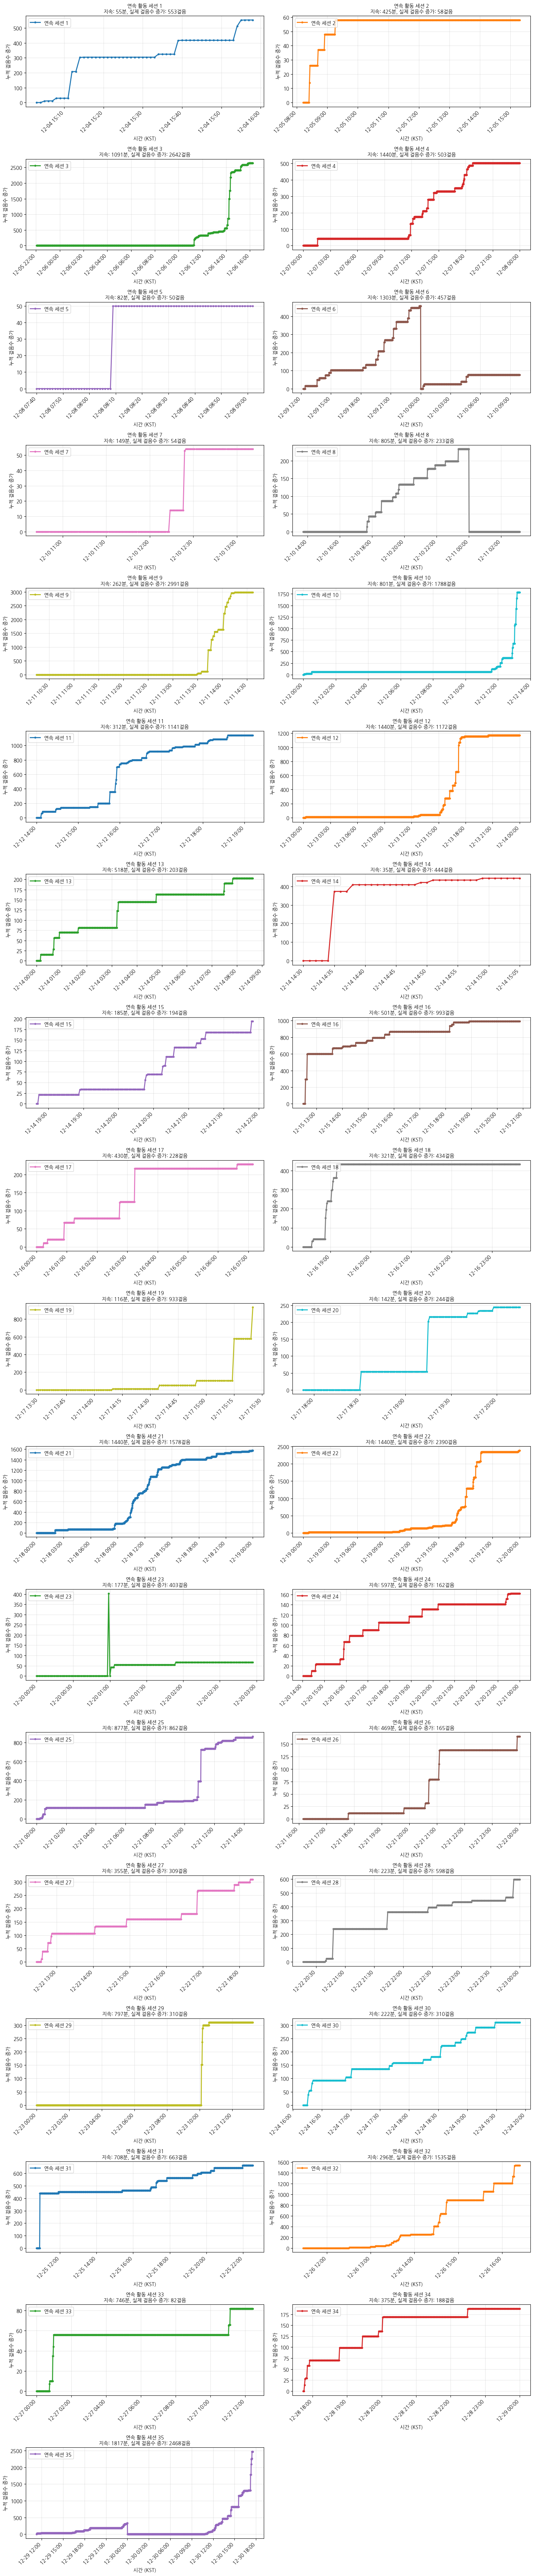

연속 세션 데이터 저장: /content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터/baXYZZcSdeVQOJiogHgziaoNAbn1/processed/watch_step_count_continuous_sessions.csv
1분 단위 데이터 저장: /content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터/baXYZZcSdeVQOJiogHgziaoNAbn1/processed/watch_step_count_sessions_normalized_minutes.csv
세션 요약 저장: /content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터/baXYZZcSdeVQOJiogHgziaoNAbn1/processed/watch_step_count_session_summary.csv
일일 걸음수 요약 저장: /content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터/baXYZZcSdeVQOJiogHgziaoNAbn1/processed/daily_step_count_summary.csv
세션별 걸음수 요약 저장: /content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터/baXYZZcSdeVQOJiogHgziaoNAbn1/processed/session_step_count_summary.csv


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy import stats

# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 0) 전역 변수 및 설정                                                        │
# └──────────────────────────────────────────────────────────────────────────┘
BASE_DIR = "/content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터"
UID      = "baXYZZcSdeVQOJiogHgziaoNAbn1"
STEP_CSV = os.path.join(BASE_DIR, UID, "watch_step_count.csv")

# 설문별 lastUpdate를 저장할 변수
last_update_map = {}

# 이상치 탐지를 위한 임계값 설정
MAX_REASONABLE_STEPS = 100000  # 하루 최대 걸음수 (10만보)
MAX_STEPS_PER_MINUTE = 300     # 분당 최대 걸음수 (빠른 달리기)
MIN_SESSION_DURATION = 5       # 최소 세션 지속시간 (분)
SESSION_GAP_THRESHOLD = 1800   # 세션 분리 기준 (30분으로 증가)
MIN_STEPS_FOR_ACTIVITY = 50    # 활동으로 인정할 최소 걸음수 증가 (증가)
MAX_BACKWARD_TOLERANCE = 500   # 걸음수 역행 허용 범위 (새로 추가)

# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 0-1) response.csv에서 주차별 lastUpdate 정보 로드                           │
# └──────────────────────────────────────────────────────────────────────────┘
def load_week_cutoffs():
    """response.csv 파일에서 주차별 lastUpdate 정보를 로드"""
    global last_update_map

    response_path = os.path.join(BASE_DIR, UID, "response.csv")
    if os.path.exists(response_path):
        try:
            df_response = pd.read_csv(response_path, encoding="cp949")
            df_response["last_ts"] = pd.to_datetime(df_response["lastUpdate"])

            for wk in sorted(df_response["week"].unique()):
                ts = df_response.loc[df_response["week"] == wk, "last_ts"].iloc[0]
                last_update_map[wk] = ts

            print("=== 주차별 lastUpdate 정보 로드 완료 ===")
            for wk, ts in last_update_map.items():
                print(f"week {wk} lastUpdate: {ts}")
            print("=========================================\n")
        except Exception as e:
            print(f"Warning: response.csv 로드 중 오류 발생: {e}")
    else:
        print(f"Warning: response.csv 파일을 찾을 수 없습니다: {response_path}")

# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 1) 이상치 탐지 함수들                                                       │
# └──────────────────────────────────────────────────────────────────────────┘
def detect_outliers_iqr(values, multiplier=3.0):
    """IQR 방법으로 이상치 탐지"""
    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return (values < lower_bound) | (values > upper_bound)

def detect_outliers_zscore(values, threshold=3.0):
    """Z-score 방법으로 이상치 탐지"""
    if len(values) < 2:
        return np.zeros(len(values), dtype=bool)
    z_scores = np.abs(stats.zscore(values))
    return z_scores > threshold

def is_reasonable_step_value(value):
    """걸음수 값이 합리적인 범위인지 확인"""
    return 0 <= value <= MAX_REASONABLE_STEPS

def detect_sudden_jumps(values, timestamps, max_steps_per_minute=MAX_STEPS_PER_MINUTE):
    """갑작스러운 걸음수 증가 탐지"""
    if len(values) < 2:
        return np.zeros(len(values), dtype=bool)

    outliers = np.zeros(len(values), dtype=bool)

    for i in range(1, len(values)):
        time_diff = (timestamps.iloc[i] - timestamps.iloc[i-1]).total_seconds() / 60.0
        step_diff = values[i] - values[i-1]

        if time_diff > 0:
            steps_per_minute = step_diff / time_diff
            if steps_per_minute > max_steps_per_minute:
                outliers[i] = True

    return outliers

# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 2) 데이터 전처리 및 이상치 제거                                              │
# └──────────────────────────────────────────────────────────────────────────┘
def preprocess_data():
    """데이터 로드 및 기본 전처리"""
    print("=== 데이터 전처리 시작 ===")

    # 데이터 로드
    df_raw = pd.read_csv(STEP_CSV)
    # ─── 컬럼명 통일 (두 가지 포맷 모두 커버) ──────────────────────────
    if "time" in df_raw.columns:
        df_raw["timestamp"] = df_raw["time"]
    if "data" in df_raw.columns:
        df_raw["value"] = df_raw["data"]
    # ────────────────────────────────────────────────────────────────
    print(f"원본 데이터 행 수: {len(df_raw)}")
    print(df_raw.head())

    # 기본 이상치 제거 (value=1인 행들)
    df_raw = df_raw[df_raw["value"] != 1].reset_index(drop=True)
    print(f"value=1 제거 후: {len(df_raw)}")

    # 시간 변환
    # 1) 밀리초 제거: "2024-10-01T22:45:32.860Z" → "2024-10-01T22:45:32Z"
    df_raw["timestamp_clean"] = df_raw["timestamp"].str.replace(r"\.\d+Z$", "Z", regex=True)
    # 2) 깨끗해진 문자열을 ISO8601로 파싱
    df_raw["ts_utc"] = pd.to_datetime(df_raw["timestamp_clean"], utc=True)

    df_raw["ts_kst"] = df_raw["ts_utc"].dt.tz_convert("Asia/Seoul").dt.tz_localize(None)

    # 시간순 정렬
    df_raw = df_raw.sort_values("ts_kst").reset_index(drop=True)

    # 절대적 이상치 제거 (너무 큰 값들)
    reasonable_mask = df_raw["value"].apply(is_reasonable_step_value)
    df_raw = df_raw[reasonable_mask].reset_index(drop=True)
    print(f"절대적 이상치 제거 후: {len(df_raw)}")

    # 통계적 이상치 탐지
    if len(df_raw) > 10:
        outliers_iqr = detect_outliers_iqr(df_raw["value"].values, multiplier=2.5)
        outliers_zscore = detect_outliers_zscore(df_raw["value"].values, threshold=3.0)

        combined_outliers = outliers_iqr | outliers_zscore
        df_raw = df_raw[~combined_outliers].reset_index(drop=True)
        print(f"통계적 이상치 제거 후: {len(df_raw)}")

    # 갑작스러운 증가 탐지 및 제거
    if len(df_raw) > 1:
        sudden_jumps = detect_sudden_jumps(df_raw["value"].values, df_raw["ts_kst"])
        df_raw = df_raw[~sudden_jumps].reset_index(drop=True)
        print(f"갑작스러운 증가 제거 후: {len(df_raw)}")

    print("=== 데이터 전처리 완료 ===\n")
    return df_raw

# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 3) 개선된 연속성 기반 세션 분리 로직                                         │
# └──────────────────────────────────────────────────────────────────────────┘
def create_continuous_sessions(df):
    """연속성을 고려한 개선된 세션 분리 로직"""
    print("=== 연속성 기반 세션 분리 시작 ===")

    if len(df) == 0:
        return pd.DataFrame()

    sessions = []
    current_session = []
    session_id = 0

    for idx, row in df.iterrows():
        if len(current_session) == 0:
            # 첫 번째 행이거나 새로운 세션 시작
            current_session.append({
                'ts_kst': row['ts_kst'],
                'value': row['value'],
                'session_id': session_id
            })
        else:
            prev_time = current_session[-1]['ts_kst']
            prev_value = current_session[-1]['value']

            time_gap = (row['ts_kst'] - prev_time).total_seconds()
            value_diff = row['value'] - prev_value

            # 개선된 세션 분리 조건
            should_split = False

            # 1) 시간 간격이 너무 큰 경우 (30분 → 1시간으로 완화)
            if time_gap >= SESSION_GAP_THRESHOLD:
                should_split = True
                print(f"  시간 간격으로 분리: {time_gap/60:.1f}분")

            # 2) 걸음수가 큰 폭으로 역행하는 경우 (허용 범위 추가)
            elif value_diff < -MAX_BACKWARD_TOLERANCE:
                should_split = True
                print(f"  걸음수 역행으로 분리: {value_diff}")

            # 3) 시간이 역행하는 경우
            elif time_gap < 0:
                print(f"  시간 역행 데이터 건너뛰기: {time_gap}")
                continue

            if should_split:
                # 현재 세션이 충분히 길고 의미있는 활동이면 저장
                if len(current_session) > 1:
                    session_df = pd.DataFrame(current_session)
                    duration = (session_df['ts_kst'].max() - session_df['ts_kst'].min()).total_seconds() / 60
                    step_increase = session_df['value'].max() - session_df['value'].min()

                    if duration >= MIN_SESSION_DURATION and step_increase >= MIN_STEPS_FOR_ACTIVITY:
                        sessions.append(session_df)
                        print(f"  세션 {session_id} 저장: {duration:.1f}분, {step_increase}걸음")
                    else:
                        print(f"  세션 {session_id} 제외: {duration:.1f}분, {step_increase}걸음 (기준 미달)")

                # 새로운 세션 시작
                session_id += 1
                current_session = [{
                    'ts_kst': row['ts_kst'],
                    'value': row['value'],
                    'session_id': session_id
                }]
            else:
                # 같은 세션에 추가 (연속성 유지)
                current_session.append({
                    'ts_kst': row['ts_kst'],
                    'value': row['value'],
                    'session_id': session_id
                })

    # 마지막 세션 처리
    if len(current_session) > 1:
        session_df = pd.DataFrame(current_session)
        duration = (session_df['ts_kst'].max() - session_df['ts_kst'].min()).total_seconds() / 60
        step_increase = session_df['value'].max() - session_df['value'].min()

        if duration >= MIN_SESSION_DURATION and step_increase >= MIN_STEPS_FOR_ACTIVITY:
            sessions.append(session_df)
            print(f"  마지막 세션 {session_id} 저장: {duration:.1f}분, {step_increase}걸음")

    if sessions:
        result_df = pd.concat(sessions, ignore_index=True)
        # 세션 ID 재할당 (0부터 시작)
        session_mapping = {old_id: new_id for new_id, old_id in enumerate(sorted(result_df['session_id'].unique()))}
        result_df['session_id'] = result_df['session_id'].map(session_mapping)

        print(f"총 {len(sessions)}개 유효한 연속 세션 생성")
        return result_df
    else:
        print("유효한 연속 세션이 없습니다.")
        return pd.DataFrame()

# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 4) 개선된 연속성 기반 정규화 로직 (0부터 시작 보장 + 연속 세션 병합)          │
# └──────────────────────────────────────────────────────────────────────────┘
def normalize_continuous_sessions(df):
    """연속성을 고려한 정규화 - 각 세션을 0부터 시작하게 하고 연속된 0걸음 세션들을 병합"""
    print("=== 연속성 기반 정규화 시작 (개선된 버전) ===")

    if len(df) == 0:
        return df

    # 1단계: 각 세션을 0부터 시작하도록 정규화
    normalized_sessions = []
    session_info = []  # 세션 정보 저장용

    for session_id in sorted(df['session_id'].unique()):
        session_data = df[df['session_id'] == session_id].copy()
        session_data = session_data.sort_values('ts_kst').reset_index(drop=True)

        if len(session_data) < 2:
            continue

        # 세션의 시작값을 0으로 만들어 정규화 (무조건 0부터 시작)
        start_value = session_data.iloc[0]['value']
        session_data['normalized_value'] = session_data['value'] - start_value

        # 음수 값 처리 (걸음수는 감소할 수 없음)
        session_data['normalized_value'] = session_data['normalized_value'].clip(lower=0)

        # 세션 내 비정상적인 역행 제거
        if len(session_data) > 2:
            valid_indices = [0]
            prev_max = session_data.iloc[0]['normalized_value']

            for i in range(1, len(session_data)):
                current_value = session_data.iloc[i]['normalized_value']

                if current_value >= prev_max or (prev_max - current_value) <= MAX_BACKWARD_TOLERANCE:
                    valid_indices.append(i)
                    prev_max = max(prev_max, current_value)

            session_data = session_data.iloc[valid_indices].reset_index(drop=True)

        # 세션 정보 저장
        final_steps = session_data['normalized_value'].max()
        duration = (session_data['ts_kst'].max() - session_data['ts_kst'].min()).total_seconds() / 60

        session_info.append({
            'session_id': session_id,
            'data': session_data,
            'final_steps': final_steps,
            'duration': duration,
            'start_time': session_data['ts_kst'].min(),
            'end_time': session_data['ts_kst'].max()
        })

        print(f"세션 {session_id}: 실제 걸음수 {final_steps:.0f}걸음, 지속시간 {duration:.1f}분")

    # 2단계: 연속된 0걸음 세션들을 병합
    print("\n=== 연속된 0걸음 세션 병합 시작 ===")
    merged_sessions = []
    current_merge_group = []

    for i, info in enumerate(session_info):
        if info['final_steps'] <= MIN_STEPS_FOR_ACTIVITY:
            # 0걸음 세션 - 병합 그룹에 추가
            current_merge_group.append(info)
            print(f"세션 {info['session_id']}: 0걸음 세션 - 병합 대상")
        else:
            # 유효한 걸음수가 있는 세션
            # 이전에 모인 0걸음 세션들이 있다면 먼저 처리
            if current_merge_group:
                merged_session = merge_zero_step_sessions(current_merge_group)
                if merged_session is not None:
                    merged_sessions.append(merged_session)
                current_merge_group = []

            # 현재 유효한 세션 추가
            if info['duration'] >= MIN_SESSION_DURATION:
                merged_sessions.append(info)
                print(f"세션 {info['session_id']}: 유효한 활동 세션 유지")
            else:
                print(f"세션 {info['session_id']}: 지속시간 부족으로 제외")

    # 마지막에 남은 0걸음 세션들 처리
    if current_merge_group:
        merged_session = merge_zero_step_sessions(current_merge_group)
        if merged_session is not None:
            merged_sessions.append(merged_session)

    # 3단계: 최종 결과 생성
    if merged_sessions:
        final_sessions = []
        for i, session_info in enumerate(merged_sessions):
            session_data = session_info['data'].copy()
            session_data['session_id'] = i  # 새로운 세션 ID 할당
            final_sessions.append(session_data)

        result_df = pd.concat(final_sessions, ignore_index=True)
        print(f"\n정규화 및 병합 완료: {len(merged_sessions)}개 최종 세션")
        return result_df
    else:
        print("유효한 활동 세션이 없습니다.")
        return pd.DataFrame()

def merge_zero_step_sessions(session_group):
    """연속된 0걸음 세션들을 하나로 병합"""
    if not session_group:
        return None

    print(f"  {len(session_group)}개 연속 0걸음 세션을 병합")

    # 시간순으로 정렬
    session_group.sort(key=lambda x: x['start_time'])

    # 모든 세션의 데이터를 합치기
    all_data = []
    total_duration = 0

    for session in session_group:
        all_data.append(session['data'])
        total_duration += session['duration']

    # 데이터 병합
    merged_data = pd.concat(all_data, ignore_index=True)
    merged_data = merged_data.sort_values('ts_kst').reset_index(drop=True)

    # 전체를 다시 0부터 시작하도록 정규화
    if len(merged_data) > 0:
        start_value = merged_data.iloc[0]['normalized_value']
        merged_data['normalized_value'] = merged_data['normalized_value'] - start_value
        merged_data['normalized_value'] = merged_data['normalized_value'].clip(lower=0)

    # 병합된 세션이 최소 기준을 만족하는지 확인
    if total_duration >= MIN_SESSION_DURATION:
        return {
            'session_id': session_group[0]['session_id'],  # 첫 번째 세션 ID 사용
            'data': merged_data,
            'final_steps': merged_data['normalized_value'].max() if len(merged_data) > 0 else 0,
            'duration': total_duration,
            'start_time': merged_data['ts_kst'].min() if len(merged_data) > 0 else None,
            'end_time': merged_data['ts_kst'].max() if len(merged_data) > 0 else None
        }
    else:
        print(f"  병합된 세션도 지속시간 부족으로 제외: {total_duration:.1f}분")
        return None

# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 5) 세션별 1분 단위 데이터 생성                                               │
# └──────────────────────────────────────────────────────────────────────────┘
def create_minute_data(df_normalized):
    """세션별 1분 단위 누적 걸음수 계산 (시작분부터 끝분까지 0부터 정규화)"""
    if df_normalized.empty:
        return pd.DataFrame()

    # 1) 세션별 시작 시각(floor 분 단위) 구하기
    start_times = (
        df_normalized
        .groupby("session_id")["ts_kst"]
        .min()
        .dt.floor("min")
    )

    # 2) 분 단위 누적 데이터 뽑아내기
    df_min = df_normalized.copy()
    df_min["ts_minute"] = df_min["ts_kst"].dt.floor("min")
    session_minutes = (
        df_min
        .groupby(["session_id", "ts_minute"])["normalized_value"]
        .max()
        .rename("cum_steps_per_min")
        .to_frame()
        .reset_index()
    )

    # 3) asfreq → ffill → fillna 로 1분단위 전 구간 채우기
    session_list = []
    for sid, grp in session_minutes.groupby("session_id"):
        grp = grp.set_index("ts_minute").asfreq("min")

        # 시작 분 보장
        start_min = start_times.loc[sid]
        if start_min not in grp.index:
            grp.loc[start_min] = np.nan

        grp = grp.sort_index()
        grp["cum_steps_per_min"] = grp["cum_steps_per_min"].ffill().fillna(0)

        grp = grp.reset_index().assign(session_id=sid)
        session_list.append(grp)

    # 4) 합치고—여기서 baseline(최소값) 빼기!
    df_out = pd.concat(session_list, ignore_index=True) if session_list else pd.DataFrame()
    if not df_out.empty:
        df_out["cum_steps_per_min"] = (
            df_out
            .groupby("session_id")["cum_steps_per_min"]
            .transform(lambda x: x - x.min())
        )

    return df_out

# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 6) 일일 걸음수 계산 함수 (중복 제거)                                         │
# └──────────────────────────────────────────────────────────────────────────┘
def calculate_daily_steps(df_normalized):
    """일일 총 걸음수 계산 (각 세션의 실제 걸음수 증가량 합계)"""
    if len(df_normalized) == 0:
        return pd.DataFrame(), pd.DataFrame()

    # 각 세션의 실제 걸음수 증가량 계산
    session_steps = df_normalized.groupby(['session_id']).agg({
        'ts_kst': ['min', 'max'],
        'normalized_value': 'max'
    }).reset_index()

    session_steps.columns = ['session_id', 'start_time', 'end_time', 'actual_steps']
    session_steps['date'] = session_steps['start_time'].dt.date
    session_steps['duration_minutes'] = (session_steps['end_time'] - session_steps['start_time']).dt.total_seconds() / 60

    # 일별 총 걸음수 계산 (각 세션의 실제 걸음수 합계)
    daily_steps = session_steps.groupby('date').agg({
        'actual_steps': 'sum',
        'session_id': 'count',
        'duration_minutes': 'sum'
    }).reset_index()

    daily_steps.columns = ['date', 'total_daily_steps', 'session_count', 'total_activity_minutes']

    return daily_steps, session_steps

# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 7) 메인 실행 함수                                                          │
# └──────────────────────────────────────────────────────────────────────────┘
def main():
    """메인 실행 함수"""
    # 주차별 정보 로드
    load_week_cutoffs()

    # 데이터 전처리
    df_preprocessed = preprocess_data()

    if len(df_preprocessed) == 0:
        print("처리할 데이터가 없습니다.")
        return

    # 연속성 기반 세션 분리
    df_sessions = create_continuous_sessions(df_preprocessed)

    if len(df_sessions) == 0:
        print("유효한 연속 세션이 없습니다.")
        return

    # 개선된 연속성 기반 정규화 (0부터 시작 보장 + 연속 세션 병합)
    df_normalized = normalize_continuous_sessions(df_sessions)

    if len(df_normalized) == 0:
        print("정규화할 유효한 활동 세션이 없습니다.")
        return

    # 1분 단위 데이터 생성
    df_minute_data = create_minute_data(df_normalized)

    # 일일 걸음수 계산 (중복 제거된)
    daily_steps, session_steps = calculate_daily_steps(df_normalized)

    # 결과 출력
    print("\n=== 최종 처리 결과 (개선된 연속성 기반 + 0부터 시작 보장) ===")
    print(f"총 유효한 활동 세션 수: {df_normalized['session_id'].nunique()}")

    # 세션별 상세 정보
    print("\n=== 세션별 상세 정보 ===")
    for sid in sorted(df_normalized["session_id"].unique()):
        sdata = df_normalized[df_normalized["session_id"] == sid]
        start_time = sdata["ts_kst"].min()
        end_time = sdata["ts_kst"].max()
        duration = (end_time - start_time).total_seconds() / 60
        actual_steps = sdata["normalized_value"].max()  # 실제 걸음수 증가량
        start_steps = sdata["normalized_value"].min()   # 시작 걸음수 (항상 0이어야 함)

        print(f"Session {sid + 1}:")
        print(f"  시작: {start_time}")
        print(f"  종료: {end_time}")
        print(f"  지속시간: {duration:.1f}분")
        print(f"  시작 걸음수: {start_steps:.0f}걸음 (0부터 시작 확인)")
        print(f"  실제 걸음수 증가: {actual_steps:.0f}걸음")
        print(f"  데이터 포인트: {len(sdata)}개\n")

    # 일일 걸음수 출력
    if len(daily_steps) > 0:
        print("=== 일일 걸음수 요약 (중복 제거) ===")
        for _, row in daily_steps.iterrows():
            print(f"{row['date']}: {row['total_daily_steps']:.0f}걸음 "
                  f"({row['session_count']}개 세션, {row['total_activity_minutes']:.0f}분 활동)")
        print()

    # 시각화
    visualize_improved_sessions(df_minute_data, df_normalized)

    # 결과 저장
    save_improved_results(df_normalized, df_minute_data, daily_steps, session_steps)

    return df_normalized, df_minute_data, daily_steps

# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 8) 개선된 시각화 함수                                                       │
# └──────────────────────────────────────────────────────────────────────────┘
def visualize_improved_sessions(df_minute_data, df_normalized):
    """개선된 세션별 시각화"""
    if len(df_minute_data) == 0:
        print("시각화할 데이터가 없습니다.")
        return

    num_sessions = df_minute_data["session_id"].nunique()
    if num_sessions == 0:
        return

    print(f"=== {num_sessions}개 개선된 연속 세션 시각화 (0부터 시작 보장) ===")

    cols = 2
    rows = (num_sessions + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4), sharex=False)

    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = list(axes)
    else:
        axes = axes.flatten()

    for idx, sid in enumerate(sorted(df_minute_data["session_id"].unique())):
        ax = axes[idx]

        # 1분 단위 데이터
        minute_data = df_minute_data[df_minute_data["session_id"] == sid].sort_values("ts_minute")

        # 세션 정보
        sdata = df_normalized[df_normalized["session_id"] == sid]
        start_time = sdata["ts_kst"].min()
        end_time = sdata["ts_kst"].max()
        duration = (end_time - start_time).total_seconds() / 60
        actual_steps = df_minute_data[df_minute_data["session_id"]==sid]["cum_steps_per_min"].max()

        # 그래프 그리기
        ax.plot(
            minute_data["ts_minute"],
            minute_data["cum_steps_per_min"],
            marker="o",
            linestyle="-",
            markersize=3,
            linewidth=2,
            label=f"연속 세션 {sid + 1}",
            color=f"C{sid}"
        )

        ax.set_title(f"연속 활동 세션 {sid + 1}\n"
                    f"지속: {duration:.0f}분, 실제 걸음수 증가: {actual_steps:.0f}걸음",
                    fontsize=10, fontweight='bold')
        ax.set_xlabel("시간 (KST)")
        ax.set_ylabel("누적 걸음수 증가")
        ax.legend(loc="upper left")
        ax.grid(True, alpha=0.3)

        # x축 포맷팅
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # 남는 subplot 제거
    for idx in range(num_sessions, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 9) 개선된 결과 저장 함수                                                    │
# └──────────────────────────────────────────────────────────────────────────┘
def save_improved_results(df_normalized, df_minute_data, daily_steps, session_steps):
    """개선된 처리 결과를 CSV 파일로 저장"""
    output_dir = os.path.join(BASE_DIR, UID, "processed")
    os.makedirs(output_dir, exist_ok=True)

    # 정규화된 데이터 저장
    normalized_path = os.path.join(output_dir, "watch_step_count_continuous_sessions.csv")
    df_normalized.to_csv(normalized_path, index=False, encoding="utf-8-sig")
    print(f"연속 세션 데이터 저장: {normalized_path}")

    # 1분 단위 데이터 저장
    if len(df_minute_data) > 0:
        minute_path = os.path.join(output_dir, "watch_step_count_sessions_normalized_minutes.csv")
        df_minute_data.to_csv(minute_path, index=False, encoding="utf-8-sig")
        print(f"1분 단위 데이터 저장: {minute_path}")

    # 세션 요약 저장
    if len(df_normalized) > 0:
        summary_data = []
        for sid in sorted(df_normalized["session_id"].unique()):
            sdata = df_normalized[df_normalized["session_id"] == sid]
            summary_data.append({
                "session_id": sid + 1,
                "start_time": sdata["ts_kst"].min(),
                "end_time": sdata["ts_kst"].max(),
                "duration_minutes": (sdata["ts_kst"].max() - sdata["ts_kst"].min()).total_seconds() / 60,
                "actual_steps": sdata["normalized_value"].max(),  # 실제 걸음수
                "data_points": len(sdata)
            })

        df_summary = pd.DataFrame(summary_data)
        summary_path = os.path.join(output_dir, "watch_step_count_session_summary.csv")
        df_summary.to_csv(summary_path, index=False, encoding="utf-8-sig")
        print(f"세션 요약 저장: {summary_path}")

    # 일일 걸음수 저장
    if len(daily_steps) > 0:
        daily_path = os.path.join(output_dir, "daily_step_count_summary.csv")
        daily_steps.to_csv(daily_path, index=False, encoding="utf-8-sig")
        print(f"일일 걸음수 요약 저장: {daily_path}")

    # 세션별 걸음수 저장
    if len(session_steps) > 0:
        session_path = os.path.join(output_dir, "session_step_count_summary.csv")
        session_steps.to_csv(session_path, index=False, encoding="utf-8-sig")
        print(f"세션별 걸음수 요약 저장: {session_path}")

# 실행
if __name__ == "__main__":
    df_normalized, df_minute_data, daily_steps = main()

In [ ]:
# 5. Main 함수: 필요한 전처리 함수들 순서대로 호출
def main():
    # preprocess_response()
    preprocess_watch_step_count()
    # preprocess_watch_heart_rate()
    # preprocess_watch_gravity()
    # preprocess_watch_accelerometer()
    # preprocess_sleep_diary()
    # preprocess_location()

if __name__ == "__main__":
    main()

===== 주차별 걸음수 피처 (디버깅용) =====
                            uid  week  STEPS_Mean  STEPS_STD  STEPS_Max  \
0  WCbACPaBNuhUi313NtAp4bMr4xX2     0    5.064792  37.840662      775.0   
1  WCbACPaBNuhUi313NtAp4bMr4xX2     1    3.965546  34.302207      703.0   

   STEPS_Total  STEPS_Median  STEPS_ActiveRatio  STEPS_HighRatio  \
0      16572.0           0.0           0.084963         0.059902   
1       9668.0           0.0           0.084085         0.060295   

   STEPS_VeryHighRatio  ...  STEPS_Weekday_2  STEPS_Weekday_2_Missing  \
0             0.021699  ...           4206.0                        0   
1             0.017637  ...           2049.0                        0   

   STEPS_Weekday_3  STEPS_Weekday_3_Missing  STEPS_Weekday_4  \
0           1366.0                        0           4942.0   
1            543.0                        0           4575.0   

   STEPS_Weekday_4_Missing  STEPS_Weekday_5  STEPS_Weekday_5_Missing  \
0                        0            267.0           

Processing UID: WCbACPaBNuhUi313NtAp4bMr4xX2
✅ Processed WCbACPaBNuhUi313NtAp4bMr4xX2: 6273 minutes, 14 days
Processing UID: SF3OKBppJOYdGucR2vffiNF0sJO2
✅ Processed SF3OKBppJOYdGucR2vffiNF0sJO2: 5934 minutes, 14 days
Processing UID: jt6QwpW77iQgiKRAOTbFUJGofQg2
✅ Processed jt6QwpW77iQgiKRAOTbFUJGofQg2: 8644 minutes, 14 days
Processing UID: wqD6BnkBH7SHuKc70SdVYG4i4nA3
✅ Processed wqD6BnkBH7SHuKc70SdVYG4i4nA3: 5016 minutes, 14 days
Processing UID: loQKPAEgx1bBAvGop4cr9HqfCwn2
✅ Processed loQKPAEgx1bBAvGop4cr9HqfCwn2: 11940 minutes, 15 days
Processing UID: vFjJEGZ10TZjDlJwCn5lDXQFDx42
✅ Processed vFjJEGZ10TZjDlJwCn5lDXQFDx42: 9163 minutes, 15 days
Processing UID: KPqggsTAIIVIYjdqiakRwzSI3I42
✅ Processed KPqggsTAIIVIYjdqiakRwzSI3I42: 14861 minutes, 16 days
Processing UID: X5MBIpEoL5clm96GCz9vKgq0byq1
✅ Processed X5MBIpEoL5clm96GCz9vKgq0byq1: 12983 minutes, 16 days
Processing UID: EykFY0NKgJVZRfI8fGCMoZ4NPc22
✅ Processed EykFY0NKgJVZRfI8fGCMoZ4NPc22: 4608 minutes, 13 days
Processing UID: 

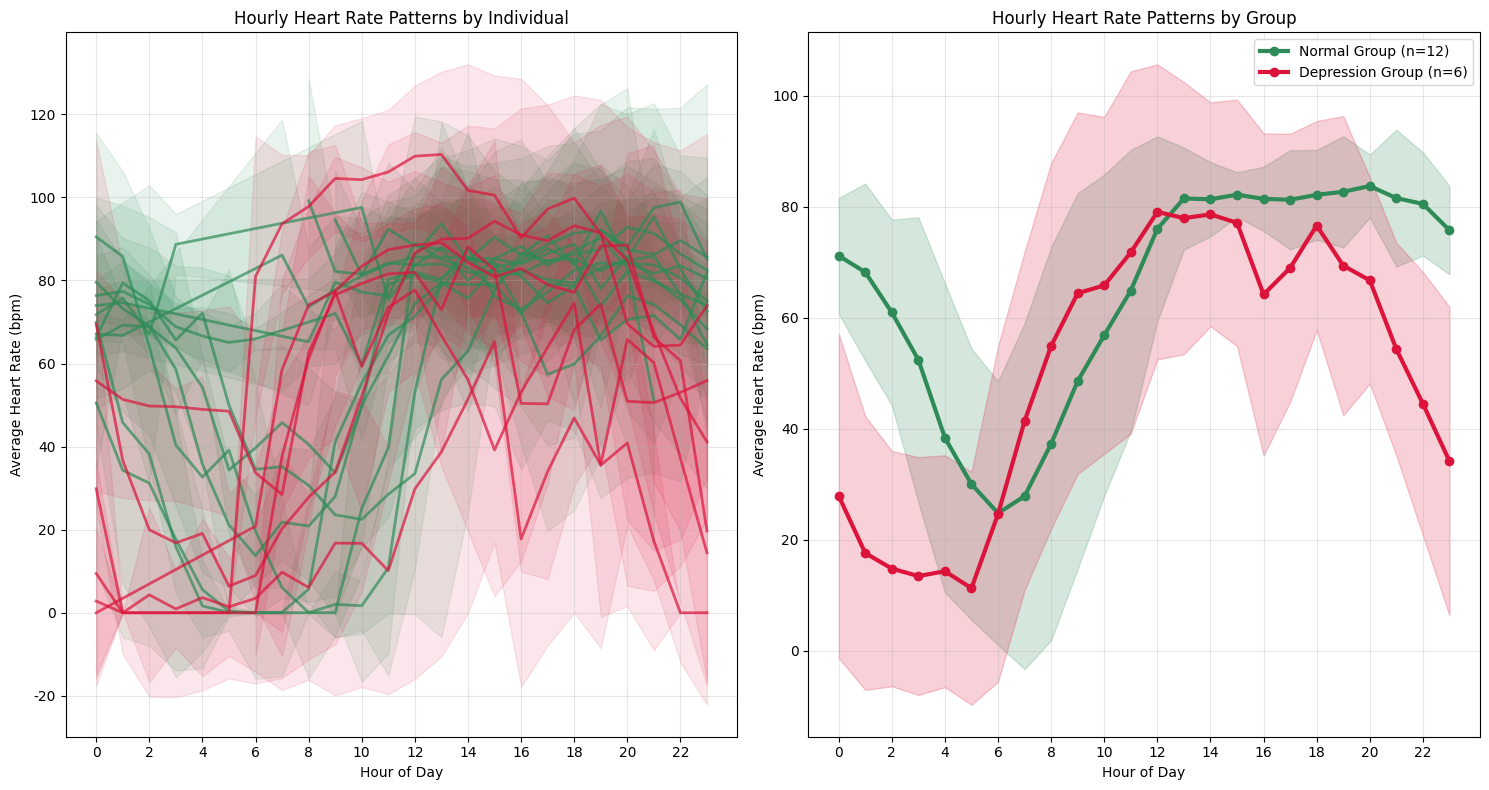

Processing UID: WCbACPaBNuhUi313NtAp4bMr4xX2
✅ Processed WCbACPaBNuhUi313NtAp4bMr4xX2: 6273 minutes, 14 days
Processing UID: SF3OKBppJOYdGucR2vffiNF0sJO2
✅ Processed SF3OKBppJOYdGucR2vffiNF0sJO2: 5934 minutes, 14 days
Processing UID: jt6QwpW77iQgiKRAOTbFUJGofQg2
✅ Processed jt6QwpW77iQgiKRAOTbFUJGofQg2: 8644 minutes, 14 days
Processing UID: wqD6BnkBH7SHuKc70SdVYG4i4nA3
✅ Processed wqD6BnkBH7SHuKc70SdVYG4i4nA3: 5016 minutes, 14 days
Processing UID: loQKPAEgx1bBAvGop4cr9HqfCwn2
✅ Processed loQKPAEgx1bBAvGop4cr9HqfCwn2: 11940 minutes, 15 days
Processing UID: vFjJEGZ10TZjDlJwCn5lDXQFDx42
✅ Processed vFjJEGZ10TZjDlJwCn5lDXQFDx42: 9163 minutes, 15 days
Processing UID: KPqggsTAIIVIYjdqiakRwzSI3I42
✅ Processed KPqggsTAIIVIYjdqiakRwzSI3I42: 14861 minutes, 16 days
Processing UID: X5MBIpEoL5clm96GCz9vKgq0byq1
✅ Processed X5MBIpEoL5clm96GCz9vKgq0byq1: 12983 minutes, 16 days
Processing UID: EykFY0NKgJVZRfI8fGCMoZ4NPc22
✅ Processed EykFY0NKgJVZRfI8fGCMoZ4NPc22: 4608 minutes, 13 days
Processing UID: 

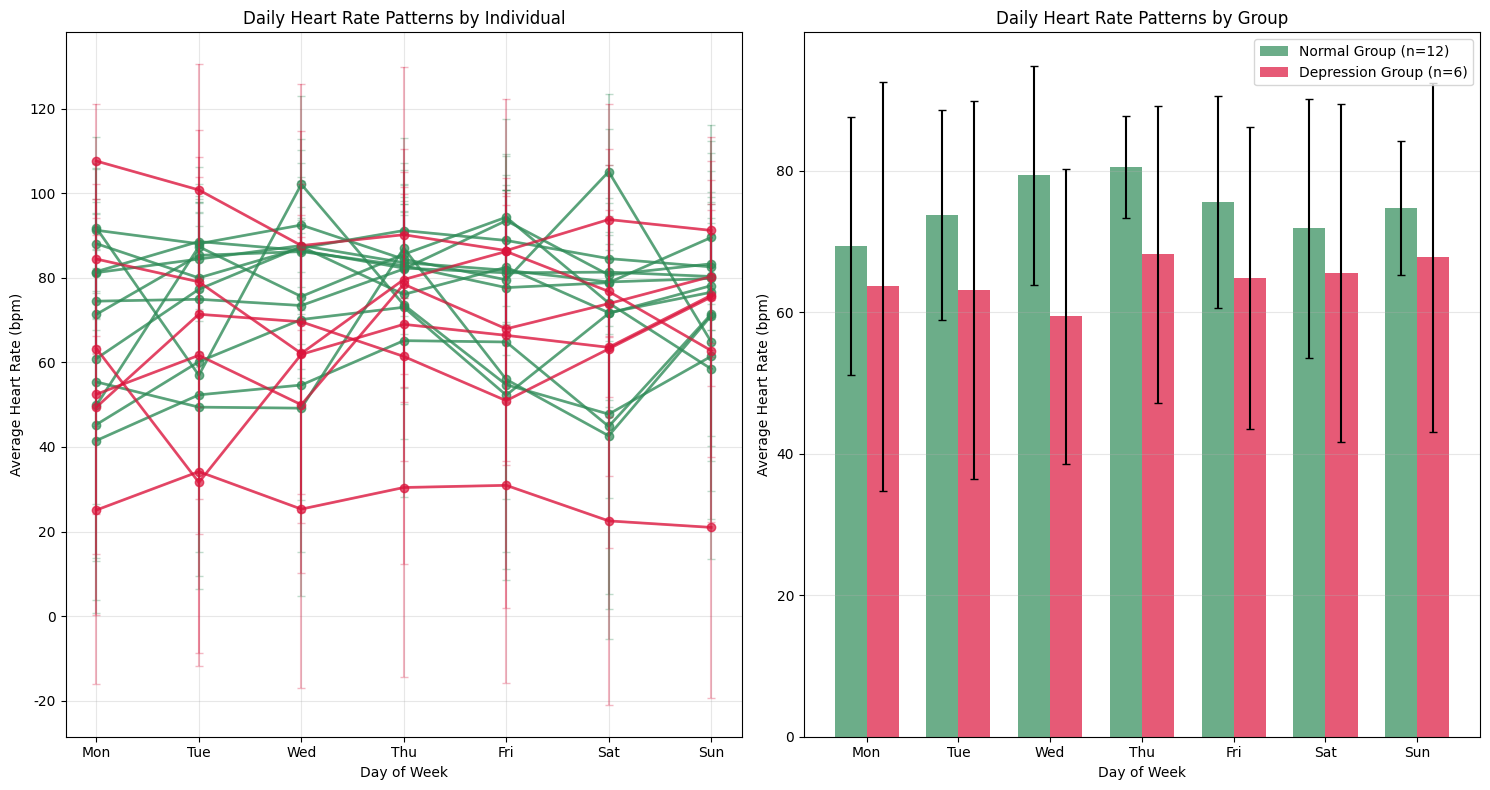

T-Test: Normal vs Depression (Daily HR Mean)
Monday:
  normal mean = 69.39, depression mean = 63.71
  T-statistic = 0.439, P-value = 0.6738
--------------------------------------------------
Tuesday:
  normal mean = 73.74, depression mean = 63.12
  T-statistic = 0.906, P-value = 0.3970
--------------------------------------------------
Wednesday:
  normal mean = 79.36, depression mean = 59.42
  T-statistic = 2.077, P-value = 0.0720
--------------------------------------------------
Thursday:
  normal mean = 80.58, depression mean = 68.19
  T-statistic = 1.408, P-value = 0.2121
--------------------------------------------------
Friday:
  normal mean = 75.60, depression mean = 64.82
  T-statistic = 1.108, P-value = 0.3018
--------------------------------------------------
Saturday:
  normal mean = 71.85, depression mean = 65.62
  T-statistic = 0.561, P-value = 0.5899
--------------------------------------------------
Sunday:
  normal mean = 74.79, depression mean = 67.77
  T-statistic = 

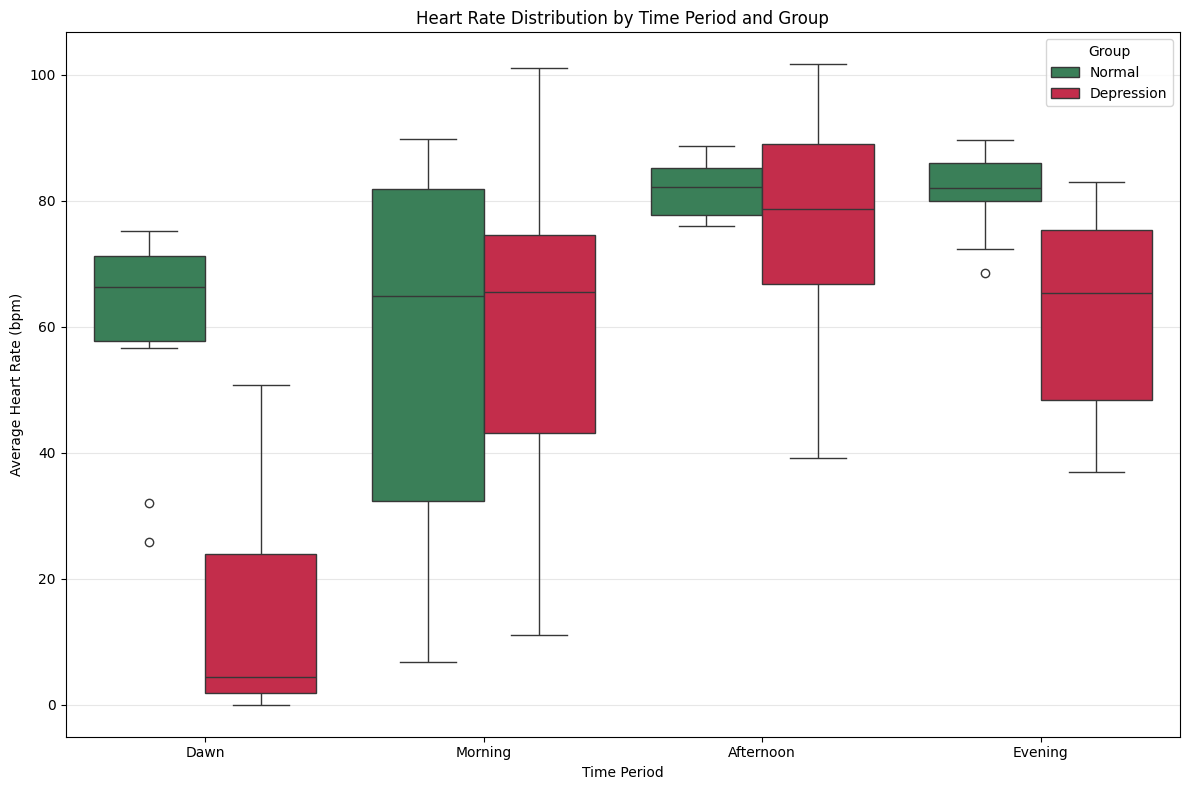

T-Test: Normal vs Depression (Time Period HR Mean)
Dawn:
  normal mean = 59.77, depression mean = 15.16
  T-statistic = 4.445, P-value = 0.0015
  👉 Significant difference (p < 0.05)
--------------------------------------------------
Morning:
  normal mean = 55.39, depression mean = 59.36
  T-statistic = -0.254, P-value = 0.8048
--------------------------------------------------
Afternoon:
  normal mean = 81.60, depression mean = 75.57
  T-statistic = 0.663, P-value = 0.5354
--------------------------------------------------
Evening:
  normal mean = 81.83, depression mean = 61.98
  T-statistic = 2.572, P-value = 0.0447
  👉 Significant difference (p < 0.05)
--------------------------------------------------
Processing UID: WCbACPaBNuhUi313NtAp4bMr4xX2
✅ Processed WCbACPaBNuhUi313NtAp4bMr4xX2: 6273 minutes, 14 days
Processing UID: SF3OKBppJOYdGucR2vffiNF0sJO2
✅ Processed SF3OKBppJOYdGucR2vffiNF0sJO2: 5934 minutes, 14 days
Processing UID: jt6QwpW77iQgiKRAOTbFUJGofQg2
✅ Processed jt6QwpW77i

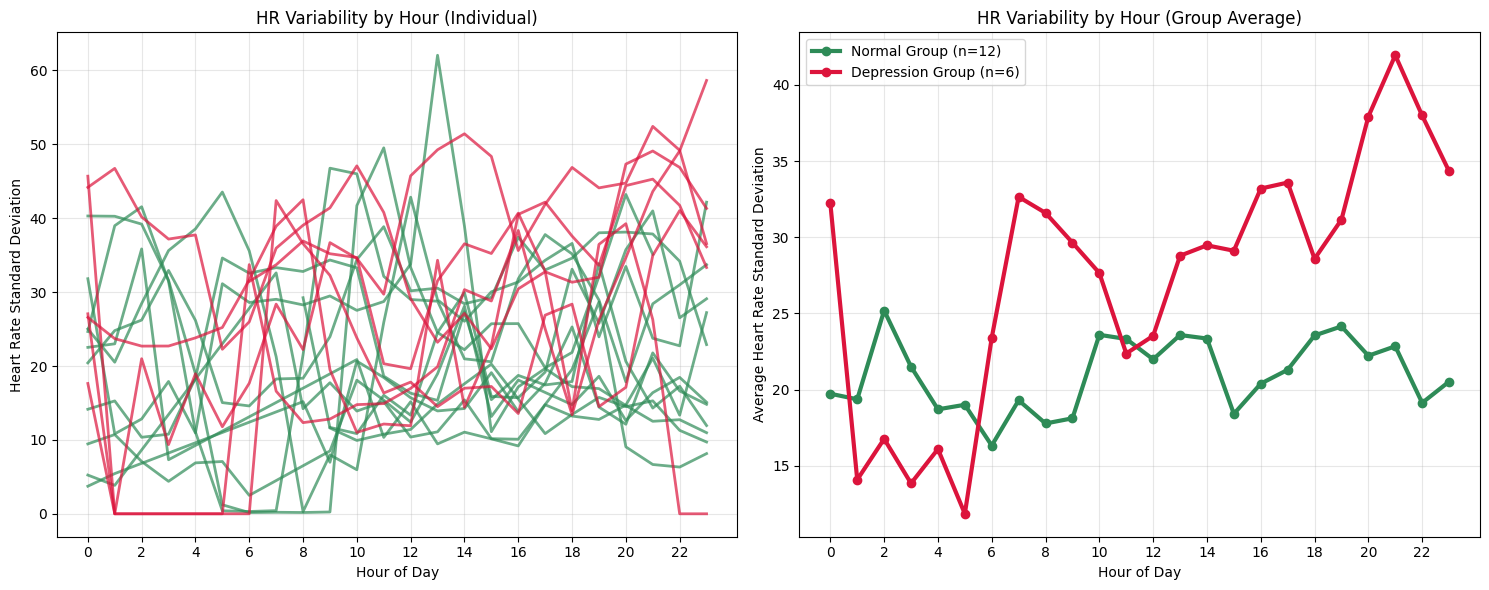

Processing UID: WCbACPaBNuhUi313NtAp4bMr4xX2
✅ Processed WCbACPaBNuhUi313NtAp4bMr4xX2: 6273 minutes, 14 days
Processing UID: SF3OKBppJOYdGucR2vffiNF0sJO2
✅ Processed SF3OKBppJOYdGucR2vffiNF0sJO2: 5934 minutes, 14 days
Processing UID: jt6QwpW77iQgiKRAOTbFUJGofQg2
✅ Processed jt6QwpW77iQgiKRAOTbFUJGofQg2: 8644 minutes, 14 days
Processing UID: wqD6BnkBH7SHuKc70SdVYG4i4nA3
✅ Processed wqD6BnkBH7SHuKc70SdVYG4i4nA3: 5016 minutes, 14 days
Processing UID: loQKPAEgx1bBAvGop4cr9HqfCwn2
✅ Processed loQKPAEgx1bBAvGop4cr9HqfCwn2: 11940 minutes, 15 days
Processing UID: vFjJEGZ10TZjDlJwCn5lDXQFDx42
✅ Processed vFjJEGZ10TZjDlJwCn5lDXQFDx42: 9163 minutes, 15 days
Processing UID: KPqggsTAIIVIYjdqiakRwzSI3I42
✅ Processed KPqggsTAIIVIYjdqiakRwzSI3I42: 14861 minutes, 16 days
Processing UID: X5MBIpEoL5clm96GCz9vKgq0byq1
✅ Processed X5MBIpEoL5clm96GCz9vKgq0byq1: 12983 minutes, 16 days
Processing UID: EykFY0NKgJVZRfI8fGCMoZ4NPc22
✅ Processed EykFY0NKgJVZRfI8fGCMoZ4NPc22: 4608 minutes, 13 days
Processing UID: 

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

class HeartRatePatternAnalyzer:
    def __init__(self, base_dir):
        """
        Heart Rate Pattern Analyzer 초기화

        Args:
            base_dir (str): 데이터가 있는 기본 디렉토리
        """
        self.base_dir = base_dir
        self.pattern_data = {}  # UID별 패턴 데이터 저장
        self.group_labels = {}  # UID별 그룹 라벨 (normal/depression)

        # 시간대 정의
        self.time_periods = {
            'Dawn': list(range(0, 6)),       # 새벽 0-5시
            'Morning': list(range(6, 12)),    # 아침 6-11시
            'Afternoon': list(range(12, 18)), # 오후 12-17시
            'Evening': list(range(18, 24))    # 저녁 18-23시
        }

        # 요일별 한글 라벨
        self.weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                              'Friday', 'Saturday', 'Sunday']

        # 컬러 팔레트
        self.colors = {
            'normal': '#2E8B57',        # 정상군: 진한 초록
            'depression': '#DC143C',    # 우울증군: 진한 빨강
            'dawn': '#FFB6C1',          # 새벽: 연한 분홍
            'morning': '#87CEEB',       # 아침: 하늘색
            'afternoon': '#FFD700',     # 오후: 금색
            'evening': '#FFA500',       # 저녁: 주황
            'night': '#4169E1'          # 밤: 로얄 블루
        }

    def get_file_path(self, uid, filename):
        """파일 경로 생성"""
        return os.path.join(self.base_dir, uid, filename)

    def load_response_data(self, uid):
        """response.csv에서 주차별 lastUpdate 정보 로드"""
        try:
            path = self.get_file_path(uid, "response.csv")
            df = pd.read_csv(path, encoding="cp949")
            df["last_ts"] = pd.to_datetime(df["lastUpdate"])

            last_update_map = {}
            for wk in sorted(df["week"].unique()):
                ts = df.loc[df["week"] == wk, "last_ts"].iloc[0]
                last_update_map[wk] = ts

            return last_update_map
        except Exception as e:
            print(f"❌ Error loading response data for {uid}: {e}")
            return {}

    def assign_week_label(self, ts_kst, cutoffs):
        """주차 라벨 할당"""
        for wk, cutoff_ts in cutoffs:
            if ts_kst < cutoff_ts:
                return wk - 1
        return cutoffs[-1][0]

    def process_uid_heart_rate(self, uid):
        """개별 UID의 심박수 데이터 처리"""
        try:
            print(f"Processing UID: {uid}")

            # 1) Response 데이터 로드
            last_update_map = self.load_response_data(uid)
            if not last_update_map:
                return False

            # 2) Heart rate 데이터 로드
            path = self.get_file_path(uid, "watch_heart_rate.csv")
            df = pd.read_csv(path)

            # 컬럼명 통일
            if "time" in df.columns:
                df["timestamp"] = df["time"]
            if "data" in df.columns:
                df["value"] = df["data"]

            # 3) 시간 처리
            df["timestamp_clean"] = df["timestamp"].str.replace(r"\.\d+Z$", "Z", regex=True)
            df["ts_utc"] = pd.to_datetime(df["timestamp_clean"], utc=True)
            df["ts_kst"] = df["ts_utc"].dt.tz_convert("Asia/Seoul").dt.tz_localize(None)

            # 4) Week cutoffs
            cutoffs = sorted([(wk, ts) for wk, ts in last_update_map.items() if wk > 0], key=lambda x: x[0])
            df["week_label"] = df["ts_kst"].apply(lambda x: self.assign_week_label(x, cutoffs))

            # 5) 1분 단위 평균
            df_min = df.set_index("ts_kst")["value"].resample("min").mean().to_frame("HR_mean")
            df_min = df_min.reset_index().rename(columns={"ts_kst": "ts_kst_min"})
            df_min["week_label"] = df_min["ts_kst_min"].apply(lambda x: self.assign_week_label(x, cutoffs))
            df_min = df_min.set_index("ts_kst_min")
            df_min = df_min.dropna()

            # 6) 시간 특성 추가
            df_min['hour'] = df_min.index.hour
            df_min['weekday'] = df_min.index.weekday
            df_min['date'] = df_min.index.date

            # 7) 시간대별 분류
            def classify_time_period(hour):
                for period, hours in self.time_periods.items():
                    if hour in hours:
                        return period
                return 'Unknown'

            df_min['time_period'] = df_min['hour'].apply(classify_time_period)

            # 8) 패턴 데이터 계산
            pattern_data = {}

            # 시간대별 평균
            hourly_pattern = df_min.groupby('hour')['HR_mean'].agg(['mean', 'std', 'count']).reset_index()
            hourly_pattern.columns = ['hour', 'hr_mean', 'hr_std', 'count']
            pattern_data['hourly'] = hourly_pattern

            # 요일별 평균
            daily_pattern = df_min.groupby('weekday')['HR_mean'].agg(['mean', 'std', 'count']).reset_index()
            daily_pattern.columns = ['weekday', 'hr_mean', 'hr_std', 'count']
            daily_pattern['weekday_name'] = daily_pattern['weekday'].apply(lambda x: self.weekday_labels[x])
            pattern_data['daily'] = daily_pattern

            # 시간대별 평균
            period_pattern = df_min.groupby('time_period')['HR_mean'].agg(['mean', 'std', 'count']).reset_index()
            period_pattern.columns = ['time_period', 'hr_mean', 'hr_std', 'count']
            pattern_data['period'] = period_pattern

            # 주말 vs 평일 비교
            df_min['is_weekend'] = df_min['weekday'].isin([5, 6])  # 토, 일
            weekend_pattern = df_min.groupby('is_weekend')['HR_mean'].agg(['mean', 'std', 'count']).reset_index()
            weekend_pattern['day_type'] = weekend_pattern['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
            pattern_data['weekend'] = weekend_pattern

            # 날짜별 평균 (시계열)
            date_pattern = df_min.groupby('date')['HR_mean'].agg(['mean', 'std', 'count']).reset_index()
            date_pattern.columns = ['date', 'hr_mean', 'hr_std', 'count']
            pattern_data['date'] = date_pattern

            # 시간대별 분산 분석
            variability_pattern = df_min.groupby('hour')['HR_mean'].agg(['std', 'var']).reset_index()
            variability_pattern.columns = ['hour', 'hr_std', 'hr_var']
            pattern_data['variability'] = variability_pattern

            # 전체 통계
            overall_stats = {
                'mean_hr': df_min['HR_mean'].mean(),
                'std_hr': df_min['HR_mean'].std(),
                'min_hr': df_min['HR_mean'].min(),
                'max_hr': df_min['HR_mean'].max(),
                'total_minutes': len(df_min),
                'total_days': len(df_min['date'].unique())
            }
            pattern_data['overall'] = overall_stats

            self.pattern_data[uid] = pattern_data
            print(f"✅ Processed {uid}: {overall_stats['total_minutes']} minutes, {overall_stats['total_days']} days")
            return True

        except Exception as e:
            print(f"❌ Error processing {uid}: {e}")
            return False

    def set_group_labels(self, group_mapping):
        """그룹 라벨 설정 (normal/depression)"""
        self.group_labels = group_mapping

    def plot_hourly_comparison(self, uids=None, figsize=(15, 8)):
        """시간대별 HR 패턴 비교"""
        if uids is None:
            uids = list(self.pattern_data.keys())

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # 개별 UID별 시간대별 패턴
        for uid in uids:
            if uid not in self.pattern_data:
                continue

            hourly_data = self.pattern_data[uid]['hourly']
            group = self.group_labels.get(uid, 'unknown')
            color = self.colors.get(group, '#808080')
            alpha = 0.7 if group != 'unknown' else 0.3

            ax1.plot(hourly_data['hour'], hourly_data['hr_mean'],
                    color=color, alpha=alpha, linewidth=2,
                    label=f'{uid} ({group})' if len(uids) <= 5 else None)

            # 표준편차 영역
            ax1.fill_between(hourly_data['hour'],
                           hourly_data['hr_mean'] - hourly_data['hr_std'],
                           hourly_data['hr_mean'] + hourly_data['hr_std'],
                           color=color, alpha=0.1)

        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Average Heart Rate (bpm)')
        ax1.set_title('Hourly Heart Rate Patterns by Individual')
        ax1.grid(True, alpha=0.3)
        ax1.set_xticks(range(0, 24, 2))
        if len(uids) <= 5:
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # 그룹별 평균 패턴
        group_hourly = {}
        for uid in uids:
            if uid not in self.pattern_data:
                continue
            group = self.group_labels.get(uid, 'unknown')
            if group not in group_hourly:
                group_hourly[group] = []
            group_hourly[group].append(self.pattern_data[uid]['hourly'])

        for group, group_data_list in group_hourly.items():
            if group == 'unknown':
                continue

            # 그룹 평균 계산
            all_hours = pd.concat(group_data_list)
            group_avg = all_hours.groupby('hour')['hr_mean'].mean()
            group_std = all_hours.groupby('hour')['hr_mean'].std()

            color = self.colors.get(group, '#808080')
            ax2.plot(group_avg.index, group_avg.values,
                    color=color, linewidth=3, marker='o',
                    markersize=6, label=f'{group.title()} Group (n={len(group_data_list)})')

            ax2.fill_between(group_avg.index,
                           group_avg.values - group_std.values,
                           group_avg.values + group_std.values,
                           color=color, alpha=0.2)

        ax2.set_xlabel('Hour of Day')
        ax2.set_ylabel('Average Heart Rate (bpm)')
        ax2.set_title('Hourly Heart Rate Patterns by Group')
        ax2.grid(True, alpha=0.3)
        ax2.set_xticks(range(0, 24, 2))
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def plot_daily_comparison(self, uids=None, figsize=(15, 8)):
        """요일별 HR 패턴 비교"""
        if uids is None:
            uids = list(self.pattern_data.keys())

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # 개별 UID별 요일별 패턴
        for uid in uids:
            if uid not in self.pattern_data:
                continue

            daily_data = self.pattern_data[uid]['daily']
            group = self.group_labels.get(uid, 'unknown')
            color = self.colors.get(group, '#808080')
            alpha = 0.7 if group != 'unknown' else 0.3

            ax1.plot(daily_data['weekday'], daily_data['hr_mean'],
                    color=color, alpha=alpha, linewidth=2, marker='o',
                    label=f'{uid} ({group})' if len(uids) <= 5 else None)

            # 에러바
            ax1.errorbar(daily_data['weekday'], daily_data['hr_mean'],
                        yerr=daily_data['hr_std'], color=color, alpha=0.3,
                        capsize=3, capthick=1)

        ax1.set_xlabel('Day of Week')
        ax1.set_ylabel('Average Heart Rate (bpm)')
        ax1.set_title('Daily Heart Rate Patterns by Individual')
        ax1.grid(True, alpha=0.3)
        ax1.set_xticks(range(7))
        ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
        if len(uids) <= 5:
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # 그룹별 평균 패턴
        group_daily = {}
        for uid in uids:
            if uid not in self.pattern_data:
                continue
            group = self.group_labels.get(uid, 'unknown')
            if group not in group_daily:
                group_daily[group] = []
            group_daily[group].append(self.pattern_data[uid]['daily'])

        # 바 차트로 그룹 비교
        x_pos = np.arange(7)
        bar_width = 0.35

        group_colors = [self.colors.get(group, '#808080') for group in group_daily.keys() if group != 'unknown']
        group_names = [group for group in group_daily.keys() if group != 'unknown']

        for i, (group, group_data_list) in enumerate(group_daily.items()):
            if group == 'unknown':
                continue

            all_days = pd.concat(group_data_list)
            group_avg = all_days.groupby('weekday')['hr_mean'].mean()
            group_std = all_days.groupby('weekday')['hr_mean'].std()

            offset = (i - 0.5) * bar_width if len(group_names) == 2 else 0
            ax2.bar(x_pos + offset, group_avg.values, bar_width,
                   color=self.colors.get(group, '#808080'), alpha=0.7,
                   yerr=group_std.values, capsize=3,
                   label=f'{group.title()} Group (n={len(group_data_list)})')

        ax2.set_xlabel('Day of Week')
        ax2.set_ylabel('Average Heart Rate (bpm)')
        ax2.set_title('Daily Heart Rate Patterns by Group')
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def plot_period_comparison(self, uids=None, figsize=(12, 8)):
        """시간대별(아침/오후/저녁/밤) HR 패턴 비교"""
        if uids is None:
            uids = list(self.pattern_data.keys())

        # 그룹별 데이터 수집
        group_data = {}
        for uid in uids:
            if uid not in self.pattern_data:
                continue
            group = self.group_labels.get(uid, 'unknown')
            if group == 'unknown':
                continue
            if group not in group_data:
                group_data[group] = []

            period_data = self.pattern_data[uid]['period']
            group_data[group].append(period_data)

        # 박스플롯 데이터 준비
        plot_data = []
        for group, group_data_list in group_data.items():
            for period_df in group_data_list:
                for _, row in period_df.iterrows():
                    plot_data.append({
                        'group': group.title(),
                        'time_period': row['time_period'],
                        'hr_mean': row['hr_mean']
                    })

        df_plot = pd.DataFrame(plot_data)

        # 원하는 순서 지정
        period_order = ['Dawn', 'Morning', 'Afternoon', 'Evening']

        # 박스플롯 생성 (order 인자로 순서 지정)
        plt.figure(figsize=figsize)
        sns.boxplot(
            data=df_plot,
            x='time_period',
            y='hr_mean',
            hue='group',
            order=period_order,
            palette=[self.colors.get(g.lower(), '#808080') for g in df_plot['group'].unique()]
        )

        plt.xlabel('Time Period')
        plt.ylabel('Average Heart Rate (bpm)')
        plt.title('Heart Rate Distribution by Time Period and Group')
        plt.legend(title='Group')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()

    def plot_variability_comparison(self, uids=None, figsize=(15, 6)):
        """시간대별 HR 변동성 비교"""
        if uids is None:
            uids = list(self.pattern_data.keys())

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # 개별 변동성 패턴
        for uid in uids:
            if uid not in self.pattern_data:
                continue

            var_data = self.pattern_data[uid]['variability']
            group = self.group_labels.get(uid, 'unknown')
            color = self.colors.get(group, '#808080')
            alpha = 0.7 if group != 'unknown' else 0.3

            ax1.plot(var_data['hour'], var_data['hr_std'],
                    color=color, alpha=alpha, linewidth=2,
                    label=f'{uid} ({group})' if len(uids) <= 5 else None)

        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Heart Rate Standard Deviation')
        ax1.set_title('HR Variability by Hour (Individual)')
        ax1.grid(True, alpha=0.3)
        ax1.set_xticks(range(0, 24, 2))
        if len(uids) <= 5:
            ax1.legend()

        # 그룹별 평균 변동성
        group_var = {}
        for uid in uids:
            if uid not in self.pattern_data:
                continue
            group = self.group_labels.get(uid, 'unknown')
            if group == 'unknown':
                continue
            if group not in group_var:
                group_var[group] = []
            group_var[group].append(self.pattern_data[uid]['variability'])

        for group, var_data_list in group_var.items():
            all_hours = pd.concat(var_data_list)
            group_avg_var = all_hours.groupby('hour')['hr_std'].mean()

            color = self.colors.get(group, '#808080')
            ax2.plot(group_avg_var.index, group_avg_var.values,
                    color=color, linewidth=3, marker='o', markersize=6,
                    label=f'{group.title()} Group (n={len(var_data_list)})')

        ax2.set_xlabel('Hour of Day')
        ax2.set_ylabel('Average Heart Rate Standard Deviation')
        ax2.set_title('HR Variability by Hour (Group Average)')
        ax2.grid(True, alpha=0.3)
        ax2.set_xticks(range(0, 24, 2))
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def generate_summary_report(self, uids=None):
        """요약 리포트 생성"""
        if uids is None:
            uids = list(self.pattern_data.keys())

        print("=" * 80)
        print("HEART RATE PATTERN ANALYSIS SUMMARY REPORT")
        print("=" * 80)

        # 그룹별 통계
        group_stats = {}
        for uid in uids:
            if uid not in self.pattern_data:
                continue
            group = self.group_labels.get(uid, 'unknown')
            if group == 'unknown':
                continue

            if group not in group_stats:
                group_stats[group] = {
                    'uids': [],
                    'mean_hrs': [],
                    'std_hrs': [],
                    'total_minutes': [],
                    'total_days': []
                }

            overall = self.pattern_data[uid]['overall']
            group_stats[group]['uids'].append(uid)
            group_stats[group]['mean_hrs'].append(overall['mean_hr'])
            group_stats[group]['std_hrs'].append(overall['std_hr'])
            group_stats[group]['total_minutes'].append(overall['total_minutes'])
            group_stats[group]['total_days'].append(overall['total_days'])

        # 그룹별 요약 출력
        for group, stats in group_stats.items():
            print(f"\n📊 {group.upper()} GROUP SUMMARY (n={len(stats['uids'])})")
            print("-" * 50)
            print(f"Average Heart Rate: {np.mean(stats['mean_hrs']):.2f} ± {np.std(stats['mean_hrs']):.2f} bpm")
            print(f"Average Variability: {np.mean(stats['std_hrs']):.2f} ± {np.std(stats['std_hrs']):.2f} bpm")
            print(f"Total Data Minutes: {np.sum(stats['total_minutes']):,} minutes")
            print(f"Total Data Days: {np.sum(stats['total_days']):,} days")
            print(f"Average Days per Subject: {np.mean(stats['total_days']):.1f} days")

            # 개별 UID 정보
            print(f"\nIndividual UIDs:")
            for i, uid in enumerate(stats['uids']):
                overall = self.pattern_data[uid]['overall']
                print(f"  {i+1}. {uid}: {overall['mean_hr']:.1f}±{overall['std_hr']:.1f} bpm "
                      f"({overall['total_days']} days)")

        # 그룹 간 비교
        if len(group_stats) >= 2:
            print(f"\n🔍 GROUP COMPARISON")
            print("-" * 50)
            groups = list(group_stats.keys())
            for i in range(len(groups)):
                for j in range(i+1, len(groups)):
                    group1, group2 = groups[i], groups[j]
                    mean1 = np.mean(group_stats[group1]['mean_hrs'])
                    mean2 = np.mean(group_stats[group2]['mean_hrs'])
                    diff = abs(mean1 - mean2)
                    print(f"{group1.title()} vs {group2.title()}: {diff:.2f} bpm difference")

        print("\n" + "=" * 80)

    def daily_ttest(self, group1='normal', group2='depression', uids=None):
        """
        요일별 평균 HR에 대해 두 그룹 간 T-Test 수행

        Args:
            group1 (str): 첫 번째 그룹명
            group2 (str): 두 번째 그룹명
            uids (list): 대상 UID 리스트 (None이면 전체)

        Returns:
            결과 출력
        """
        if uids is None:
            uids = list(self.pattern_data.keys())

        # 그룹별 요일별 HR 데이터 수집
        group_data = {group1: [], group2: []}

        for uid in uids:
            group = self.group_labels.get(uid, 'unknown')
            if group in group_data and uid in self.pattern_data:
                daily_data = self.pattern_data[uid]['daily']
                group_data[group].append(daily_data[['weekday', 'hr_mean']])

        # 데이터프레임으로 결합
        df1 = pd.concat(group_data[group1])
        df2 = pd.concat(group_data[group2])

        print("="*70)
        print(f"T-Test: {group1.title()} vs {group2.title()} (Daily HR Mean)")
        print("="*70)

        for day in range(7):
            # 요일별로 필터
            hr1 = df1[df1['weekday'] == day]['hr_mean'].values
            hr2 = df2[df2['weekday'] == day]['hr_mean'].values

            if len(hr1) < 2 or len(hr2) < 2:
                print(f"{self.weekday_labels[day]}: Not enough data for T-Test.")
                continue

            t_stat, p_value = ttest_ind(hr1, hr2, equal_var=False)  # Welch’s T-Test

            print(f"{self.weekday_labels[day]}:")
            print(f"  {group1} mean = {np.mean(hr1):.2f}, {group2} mean = {np.mean(hr2):.2f}")
            print(f"  T-statistic = {t_stat:.3f}, P-value = {p_value:.4f}")
            if p_value < 0.05:
                print("  👉 Significant difference (p < 0.05)")
            print("-"*50)

    def time_period_ttest(self, group1='normal', group2='depression', uids=None):
        """
        시간대별(Time Period) HR 평균에 대해 두 그룹 간 T-Test 수행

        Args:
            group1 (str): 첫 번째 그룹명 (기본 normal)
            group2 (str): 두 번째 그룹명 (기본 depression)
            uids (list): UID 리스트 (None이면 전체)
        """
        if uids is None:
            uids = list(self.pattern_data.keys())

        # 그룹별 데이터 수집
        group_data = {group1: [], group2: []}

        for uid in uids:
            group = self.group_labels.get(uid, 'unknown')
            if group in group_data and uid in self.pattern_data:
                period_data = self.pattern_data[uid]['period']
                group_data[group].append(period_data[['time_period', 'hr_mean']])

        df1 = pd.concat(group_data[group1])
        df2 = pd.concat(group_data[group2])

        print("="*70)
        print(f"T-Test: {group1.title()} vs {group2.title()} (Time Period HR Mean)")
        print("="*70)

        # 시간대별 순서
        period_order = ['Dawn', 'Morning', 'Afternoon', 'Evening']

        for period in period_order:
            hr1 = df1[df1['time_period'] == period]['hr_mean'].values
            hr2 = df2[df2['time_period'] == period]['hr_mean'].values

            if len(hr1) < 2 or len(hr2) < 2:
                print(f"{period}: Not enough data for T-Test.")
                continue

            t_stat, p_value = ttest_ind(hr1, hr2, equal_var=False)

            print(f"{period}:")
            print(f"  {group1} mean = {np.mean(hr1):.2f}, {group2} mean = {np.mean(hr2):.2f}")
            print(f"  T-statistic = {t_stat:.3f}, P-value = {p_value:.4f}")
            if p_value < 0.05:
                print("  👉 Significant difference (p < 0.05)")
            print("-"*50)

    def run_comprehensive_analysis(self, uids, group_mapping):
        """종합적인 분석 실행"""
        print("🚀 Starting Comprehensive Heart Rate Pattern Analysis")
        print("=" * 60)

        # 그룹 라벨 설정
        self.set_group_labels(group_mapping)

        # 각 UID 데이터 처리
        successful_uids = []
        for uid in uids:
            if self.process_uid_heart_rate(uid):
                successful_uids.append(uid)

        if not successful_uids:
            print("❌ No data processed successfully.")
            return

        print(f"\n✅ Successfully processed {len(successful_uids)} UIDs")

        # 요약 리포트
        self.generate_summary_report(successful_uids)

        # 시각화
        print("\n📈 Generating Visualizations...")

        print("1. Hourly Pattern Comparison...")
        self.plot_hourly_comparison(successful_uids)

        print("2. Daily Pattern Comparison...")
        self.plot_daily_comparison(successful_uids)

        print("3. Time Period Comparison...")
        self.plot_period_comparison(successful_uids)

        print("4. Weekend vs Weekday Comparison...")
        self.plot_weekend_comparison(successful_uids)

        print("5. Variability Analysis...")
        self.plot_variability_comparison(successful_uids)

        print("\n✅ Analysis completed!")
        return successful_uids


# 편의 함수들
def quick_group_comparison(base_dir, normal_uids, depression_uids, analysis_type='hourly'):
    """빠른 그룹 비교 (특정 분석만)"""
    analyzer = HeartRatePatternAnalyzer(base_dir)

    # 그룹 매핑
    group_mapping = {uid: 'normal' for uid in normal_uids}
    group_mapping.update({uid: 'depression' for uid in depression_uids})
    analyzer.set_group_labels(group_mapping)

    # 데이터 처리
    all_uids = normal_uids + depression_uids
    successful_uids = []
    for uid in all_uids:
        if analyzer.process_uid_heart_rate(uid):
            successful_uids.append(uid)

    if not successful_uids:
        print("❌ No data processed successfully.")
        return []

    # 선택한 분석 유형에 따라 실행
    if analysis_type == 'hourly':
        # 시간대별 패턴 비교
        analyzer.plot_hourly_comparison(successful_uids)
    elif analysis_type == 'daily':
        # 요일별 패턴 비교
        analyzer.plot_daily_comparison(successful_uids)
        analyzer.daily_ttest(group1='normal', group2='depression')
    elif analysis_type == 'period':
        # 시간 구간별(새벽/아침/오후/저녁/밤) 패턴 비교
        analyzer.plot_period_comparison(successful_uids)
        analyzer.time_period_ttest(group1='normal', group2='depression')
    elif analysis_type == 'weekend':
        # 주말 vs 평일 패턴 비교
        analyzer.plot_weekend_comparison(successful_uids)
    elif analysis_type == 'variability':
        # 시간대별 변동성 비교
        analyzer.plot_variability_comparison(successful_uids)
    elif analysis_type == 'summary':
        # 요약 리포트 출력
        analyzer.generate_summary_report(successful_uids)
    else:
        raise ValueError(f"Unknown analysis_type: {analysis_type}")

    return successful_uids


# 예시 사용법
if __name__ == "__main__":
    # 데이터가 저장된 경로를 지정하세요
    base_dir = "/content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터"
    # 정상군과 우울증군 UID 리스트
    normal_uids = [
        'WCbACPaBNuhUi313NtAp4bMr4xX2',
        'SF3OKBppJOYdGucR2vffiNF0sJO2',
        'jt6QwpW77iQgiKRAOTbFUJGofQg2',
        'wqD6BnkBH7SHuKc70SdVYG4i4nA3',
        'loQKPAEgx1bBAvGop4cr9HqfCwn2',
        'vFjJEGZ10TZjDlJwCn5lDXQFDx42',
        'KPqggsTAIIVIYjdqiakRwzSI3I42',
        'X5MBIpEoL5clm96GCz9vKgq0byq1',
        'EykFY0NKgJVZRfI8fGCMoZ4NPc22',
        'FG6WOuZMWtgArSWGCi9MIgu4KVo1',
        '96AOPONmdGeAwZNwMtXcRumiCqV2',
        'OR2z2fOOaIM8M2obfI4YvSd7Cz03',
        ]

    depression_uids = [
        'baXYZZcSdeVQOJiogHgziaoNAbn1',
        'JHXGbmkWxYOrH4mKT31aXvOaU1I3',
        'tZknnycQKNdJYvmp3OSSNLY6Ku92',
        'H5xpe8R0pMQNybyFmD6fpptb5s12',
        'aEbEJ4v5ZXOGXpRj4con8TY5Oks1',
        'OtvWlOKX52Zi1Qyky0yYrFxvEGT2',
        ]

    # 시간대별 패턴 비교
    quick_group_comparison(base_dir, normal_uids, depression_uids, analysis_type='hourly')

    # 요일별 패턴 비교
    quick_group_comparison(base_dir, normal_uids, depression_uids, analysis_type='daily')

    # 시간 구간별(아침/오후/저녁/밤) 패턴 비교
    quick_group_comparison(base_dir, normal_uids, depression_uids, analysis_type='period')

    # 시간대별 변동성 비교
    quick_group_comparison(base_dir, normal_uids, depression_uids, analysis_type='variability')

    # 요약 리포트 출력
    quick_group_comparison(base_dir, normal_uids, depression_uids, analysis_type='summary')


In [ ]:
import os
import pandas as pd
import numpy as np

BASE_DIR = "/content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터"

participant_uids = [
    "WCbACPaBNuhUi313NtAp4bMr4xX2",
    "SF3OKBppJOYdGucR2vffiNF0sJO2",
    "jt6QwpW77iQgiKRAOTbFUJGofQg2",
    "wqD6BnkBH7SHuKc70SdVYG4i4nA3",
    "loQKPAEgx1bBAvGop4cr9HqfCwn2",
    "vFjJEGZ10TZjDlJwCn5lDXQFDx42",
    "KPqggsTAIIVIYjdqiakRwzSI3I42",
    "X5MBIpEoL5clm96GCz9vKgq0byq1",
    "EykFY0NKgJVZRfI8fGCMoZ4NPc22",
    "FG6WOuZMWtgArSWGCi9MIgu4KVo1",
    "96AOPONmdGeAwZNwMtXcRumiCqV2",
    "OR2z2fOOaIM8M2obfI4YvSd7Cz03",
    "H5xpe8R0pMQNybyFmD6fpptb5s12",
    "aEbEJ4v5ZXOGXpRj4con8TY5Oks1",
    "OtvWlOKX52Zi1Qyky0yYrFxvEGT2",
    "tZknnycQKNdJYvmp3OSSNLY6Ku92",
    "JHXGbmkWxYOrH4mKT31aXvOaU1I3",
    "baXYZZcSdeVQOJiogHgziaoNAbn1",
]

for uid in participant_uids:
    print(f"\n▶ Processing UID: {uid}")
    pre_dir = os.path.join(BASE_DIR, uid, "processed")
    # 각 파일 경로
    hr_path    = os.path.join(pre_dir, "watch_heart_rate_processed.csv")
    steps_path = os.path.join(pre_dir, "watch_step_count_processed.csv")
    resp_path  = os.path.join(pre_dir, "response_processed.csv")

    # 파일 로드
    df_hr    = pd.read_csv(hr_path)
    df_steps = pd.read_csv(steps_path)
    df_resp  = pd.read_csv(resp_path)

    # 중복 주차 제거
    df_steps = df_steps.drop_duplicates(subset=["week"])
    df_resp  = df_resp .drop_duplicates(subset=["week"])

    # 1차 병합: HRV + Steps
    df_tmp = df_hr.merge(
        df_steps,
        on="week",
        how="left",
        suffixes=("", "_dup")
    )
    dup_cols = [c for c in df_tmp.columns if c.endswith("_dup")]
    df_tmp.drop(columns=dup_cols, inplace=True)

    # 2차 병합: + Response
    df_tmp = df_tmp.merge(
        df_resp,
        on="week",
        how="left",
        suffixes=("", "_dup")
    )
    dup_cols = [c for c in df_tmp.columns if c.endswith("_dup")]
    df_tmp.drop(columns=dup_cols, inplace=True)

    # NaN 처리
    df_tmp["STEPS_Total"] = df_tmp.get("STEPS_Total", 0).fillna(0)
    other_cols = [c for c in df_tmp.columns if c != "STEPS_Total"]
    df_tmp.dropna(subset=other_cols, inplace=True)

    # 결과 저장
    out_path = os.path.join(pre_dir, "train_data.csv")
    df_tmp.to_csv(out_path, index=False)
    print(f"  - 저장 완료: {out_path} (shape: {df_tmp.shape})")







▶ Processing UID: WCbACPaBNuhUi313NtAp4bMr4xX2
  - 저장 완료: /content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터/WCbACPaBNuhUi313NtAp4bMr4xX2/processed/train_data.csv (shape: (2, 210))

▶ Processing UID: SF3OKBppJOYdGucR2vffiNF0sJO2
  - 저장 완료: /content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터/SF3OKBppJOYdGucR2vffiNF0sJO2/processed/train_data.csv (shape: (2, 210))

▶ Processing UID: jt6QwpW77iQgiKRAOTbFUJGofQg2
  - 저장 완료: /content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터/jt6QwpW77iQgiKRAOTbFUJGofQg2/processed/train_data.csv (shape: (2, 210))

▶ Processing UID: wqD6BnkBH7SHuKc70SdVYG4i4nA3
  - 저장 완료: /content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터/wqD6BnkBH7SHuKc70SdVYG4i4nA3/processed/train_data.csv (shape: (3, 210))

▶ Processing UID: loQKPAEgx1bBAvGop4cr9HqfCwn2
  - 저장 완료: /content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터/loQKPAEgx1bBAvGop4cr9HqfCwn2/processed/train_data.csv (shape: (2, 210))


In [ ]:
import os
import pandas as pd

# 1) 기본 경로와 UID 리스트 설정
BASE_DIR = "/content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터"
participant_uids = [
    "WCbACPaBNuhUi313NtAp4bMr4xX2",
    "SF3OKBppJOYdGucR2vffiNF0sJO2",
    "jt6QwpW77iQgiKRAOTbFUJGofQg2",
    "wqD6BnkBH7SHuKc70SdVYG4i4nA3",
    "loQKPAEgx1bBAvGop4cr9HqfCwn2",
    "vFjJEGZ10TZjDlJwCn5lDXQFDx42",
    "KPqggsTAIIVIYjdqiakRwzSI3I42",
    "X5MBIpEoL5clm96GCz9vKgq0byq1",
    "EykFY0NKgJVZRfI8fGCMoZ4NPc22",
    "FG6WOuZMWtgArSWGCi9MIgu4KVo1",
    "96AOPONmdGeAwZNwMtXcRumiCqV2",
    "OR2z2fOOaIM8M2obfI4YvSd7Cz03",
    "H5xpe8R0pMQNybyFmD6fpptb5s12",
    "aEbEJ4v5ZXOGXpRj4con8TY5Oks1",
    "OtvWlOKX52Zi1Qyky0yYrFxvEGT2",
    "tZknnycQKNdJYvmp3OSSNLY6Ku92",
    "JHXGbmkWxYOrH4mKT31aXvOaU1I3",
    "baXYZZcSdeVQOJiogHgziaoNAbn1",
]

# 2) train.csv 파일들을 읽어서 리스트에 저장
df_list = []
for uid in participant_uids:
    file_path = os.path.join(BASE_DIR, uid, "processed", "train_data.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        # 원한다면 uid 컬럼 추가
        df["uid"] = uid
        df_list.append(df)
    else:
        print(f"[경고] 파일을 찾을 수 없음: {file_path}")

# 3) 모두 합치기
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    # 4) 합친 데이터 저장
    out_path = os.path.join(BASE_DIR, "combined_train_data.csv")
    combined_df.to_csv(out_path, index=False, encoding="utf-8-sig")
    print(f"모든 train.csv 병합 완료 → {out_path}")
    print("합쳐진 DataFrame 크기:", combined_df.shape)
else:
    print("읽을 train.csv 파일이 없습니다.")


모든 train.csv 병합 완료 → /content/drive/MyDrive/가천대/RA/[wearable] 과제/HRV 분석/Datas/MongoDB 데이터/combined_train_data.csv
합쳐진 DataFrame 크기: (68, 210)
